# NBA Project
## Tomasz Rybnik

### Projekt na zaliczenie DATA SCIENCE BOOTCAMP
### Pomysł własny: 
#### Zbudowanie modelu przewidującego, czy ustalona drużyna NBA wygra z inną, ustaloną drużyną NBA. 
#### Cechy wyróżniające projektu:
#### 0. realizacja własnej koncepcji badawczej
#### 1. rozbudowany web-scrapping w celu pozyskania zbioru do analiz
#### 2. opracowanie koncepcji zmiennej target
#### 3. rozbudowany feature engineering
#### 4. dynamizacja charakterystyk na poziomie drużyny
#### 5. przygotowanie finalnego zbioru oczyszczonych danych
#### 6. przetestowanie wielu technik z zakresu klasyfikacji
#### 7. wybranie najlepszej techniki i ocena modelu

### UWAGA. Wszystkie kody pisane były samodzielnie (oczywiście, częściowo jest to kompilacja kodów z zajęć i małych fragmentów do specyficznych rozwiązań, które znalazłem w sieci): zdaję sobie sprawę z braku efektywności kodu oraz potencjalnej częściowej chaotyczności, który się w niego wkradł. Kod został przejrzany i do pewnego stopnia uporządkowany, jednak, jako że etap przygotowywania danych okazał się bardzo rozbudowany i czasochłonny (i tak spora część pomysłów wzbogacenia zbioru uczącego o treść informacyjną "leży jeszcze na półce"), nacisk położony został na inne aspekty (koncepcja, weryfikcja poprawności wykorzystywanych danych, modelowanie). Część komentarzy w kodzie jest po angielsku - to naleciałość zawodowa, z którą trudno mi walczyć.

### Przy budowniu koncepcji modelu, założyłem, że:
### 1. na wynik wpływają charakterystyki (performance) 5-ciu najlepszych graczy drużyny oraz kombinacja charakterystyk pozostałej części graczy
### 2. na wynik wpływają charakterystyki samej drużyny oraz drużyny przeciwnej - jak drużyna gra w ogólności, jak jej idzie ostatnio, jaki to punkt sezonu i czy jest o co walczyć, itd.

## 1. rozbudowany web-scrapping w celu pozyskania zbioru do analiz

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
#player list plus podstawowe statystyki per zawodnik

# NBA season we will be analyzing (2018/2019)
# każdy sezon jest na swój sposób unikalny, choć na którymś etapie projektu, podjęta została próba włączenia danych z innych sezonów 
year = 2019

url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html".format(year)
html = urlopen(url)
soup = BeautifulSoup(html)
headers_adv = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
headers_adv = headers_adv[1:]
rows = soup.findAll('tbody')[0].findAll('tr')[0:]
player_stats = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]
stats = pd.DataFrame(player_stats, columns = headers_adv)
stats = stats[pd.notna(stats.G)]
stats.reset_index(drop=True, inplace=True)
name_split = stats["Player"].str.split(" ", n = 1, expand = True) 
stats["First Name"]= name_split[0] 
stats["Last Name"]= name_split[1] 
#stats.head(2)
stats2 = stats.set_index("Player", drop = False)
#stats2.head(3)

In [3]:
# zaawansowane statystyki per zawodnik
year = 2019
urla = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html".format(year)
htmla = urlopen(urla)
soupa= BeautifulSoup(htmla)
headers_adva = [th.getText() for th in soupa.findAll('tr', limit=2)[0].findAll('th')]
headers_adva = headers_adva[1:]
headers_adva[18]='None1'
headers_adva[23]='None2'
headers_adva

rowsa = soupa.findAll('tbody')[0].findAll('tr')[0:]
player_statsa = [[td.getText() for td in rowsa[i].findAll('td')]
            for i in range(len(rowsa))]
statsa = pd.DataFrame(player_statsa, columns = headers_adva)
statsa = statsa[pd.notna(statsa.G)]
statsa.reset_index(drop=True, inplace=True)
name_split = statsa["Player"].str.split(" ", n = 1, expand = True) 
statsa["First Name"]= name_split[0] 
statsa["Last Name"]= name_split[1] 
statsa=statsa.drop(['None1','None2'], axis=1)
statsa=statsa.rename(columns={'MP':'MP_sum'})
statsa.head(2)

,Player,Pos,Age,Tm,G,MP_sum,PER,TS%,3PAr,FTr,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,First Name,Last Name
0,Alex Abrines,SG,25,OKC,31,588,6.3,.507,.809,.083,...,0.1,0.6,0.6,.053,-2.4,-0.9,-3.4,-0.2,Alex,Abrines
1,Quincy Acy,PF,28,PHO,10,123,2.9,.379,.833,.556,...,-0.1,0.0,-0.1,-0.022,-5.7,-0.3,-5.9,-0.1,Quincy,Acy


In [4]:
stats_new = stats.sort_values(by=['Last Name','First Name','G','Tm'] ,ascending=False)
stats_new = stats_new.loc[stats_new['Tm'] != 'TOT'].drop_duplicates(['Player'])
# stats_new.head(3)

stats_newa = statsa.sort_values(by=['Last Name','First Name','G','Tm'] ,ascending=False)
stats_newa = stats_newa.loc[stats_newa['Tm'] != 'TOT'].drop_duplicates(['Player'])
stats_newa = stats_newa.drop(['First Name','Last Name'], axis=1)
# stats_newa.head(3)

In [5]:
# tworzenie DF plus konwersja na zmienne numeryczne
stats_new2=pd.DataFrame()
stats_new2=stats_new
llist=list(stats_new.columns.values)
llist = [e for e in llist if e not in ('Player','Pos','Date','Tm','At','Opp','Result','Last Name','First Name')]
for i in llist:
    stats_new2[i]=pd.to_numeric(stats_new[i],errors='coerce')

stats_newa2=pd.DataFrame()
stats_newa2=stats_newa
llista=list(stats_newa.columns.values)
llista = [e for e in llista if e not in ('Player','Pos','Date','Tm','At','Opp','Result','Last Name','First Name')]
for i in llista:
    stats_newa2[i]=pd.to_numeric(stats_newa[i],errors='coerce')

In [6]:
#merging (statystyki podstawowe i zaawansowane):
stats_new2_fin = stats_new2.merge(stats_newa2,'left', on=('Player','Pos', 'Age', 'Tm', 'G'))
stats_new2_fin.shape
# stats_new2_fin.head(5)

(530, 52)

## ideą jest, żeby wybrać 5-ciu najlepszych (i odpowiednio aktywnych) zawodników każdej drużyny i opisywać drużynę charakterystykami indywidualnymi tych zawodników oraz zbiorczymi charakterystykami pozostałej części zawodników (również odpowiednio aktywnych). Wybieranie będzie automatyczne i oparte o rating wynikający z wszechstronnej oceny gry zawodników: im większa WAŻONAsuma wystandaryzowanych/unormowanych wyników (wybranych ekspercko; per drużyna), tym wyżej zawodnik w rankingu.

## 3. rozbudowany feature engineering (nie tylko tu) 

In [9]:
# wyznaczenie (per drużyna) średnich i odchyleń std dla wybranych statystyk - wartości potrzebne 
# do normowania statystyk poszczególnych graczy i stworzenia później ich rankingu (per drużyna)

import pandas as pd
import numpy as np

table = pd.pivot_table(stats_new2_fin, values=['MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'MP_sum', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'],
                       
                       index=['Tm'],
                   aggfunc={np.mean, np.std})#.columns()

table.columns
table.head(3)

2P                 2P%                 2PA                  3P  \
         mean       std      mean       std      mean       std      mean   
Tm                                                                          
ATL  1.961905  1.564122  0.502000  0.095382  3.771429  2.744475  0.909524   
BOS  2.381250  1.671813  0.543750  0.072385  4.481250  3.161270  1.175000   
BRK  2.200000  1.336809  0.545889  0.143393  4.200000  2.725263  0.977778   

                    3P%              ...          USG%                VORP  \
          std      mean       std    ...          mean       std      mean   
Tm                                   ...                                     
ATL  0.605727  0.364250  0.176612    ...     17.528571  4.384877  0.138095   
BOS  1.042753  0.355400  0.041052    ...     18.581250  4.460227  0.925000   
BRK  0.934033  0.232444  0.155089    ...     19.805556  5.826054  0.533333   

                     WS               WS/48                eFG%            
          std      mean       std      mean       std      mean       std  
Tm                                                                         
ATL  0.487315  1.323810  1.607142  0.066810  0.061382  0.568762  0.226732  
BOS  1.378163  3.250000  2.681542  0.133937  0.050559  0.543000  0.062626  
BRK  0.986974  2.311111  2.390149  0.093556  0.100965  0.519056  0.075055  

[3 rows x 88 columns]

In [10]:
#zmiana nazw
table.columns=['_'.join(str(s).strip() for s in col if s).strip('_') for col in table.columns]
table['Tm'] = table.index
table.reset_index(drop=True)
table.head(3)

,2P_mean,2P_std,2P%_mean,2P%_std,2PA_mean,2PA_std,3P_mean,3P_std,3P%_mean,3P%_std,...,USG%_std,VORP_mean,VORP_std,WS_mean,WS_std,WS/48_mean,WS/48_std,eFG%_mean,eFG%_std,Tm
Tm,,,,,,,,,,,,,,,,,,,,,
ATL,1.961905,1.564122,0.502000,0.095382,3.771429,2.744475,0.909524,0.605727,0.364250,0.176612,...,4.384877,0.138095,0.487315,1.323810,1.607142,0.066810,0.061382,0.568762,0.226732,ATL
BOS,2.381250,1.671813,0.543750,0.072385,4.481250,3.161270,1.175000,1.042753,0.355400,0.041052,...,4.460227,0.925000,1.378163,3.250000,2.681542,0.133937,0.050559,0.543000,0.062626,BOS
BRK,2.200000,1.336809,0.545889,0.143393,4.200000,2.725263,0.977778,0.934033,0.232444,0.155089,...,5.826054,0.533333,0.986974,2.311111,2.390149,0.093556,0.100965,0.519056,0.075055,BRK


In [11]:
# dodanie wartości do normalizacji 

stats_fin2 = stats_new2_fin.merge(table,'left', on=('Tm'))
stats_fin2.shape


(530, 140)

In [12]:
# normalizacja
stats_fin3 = stats_fin2
liss=['MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'MP_sum', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
#liss=['MP', 'FG']
for j in liss:
    ind = j+'_stdz'
    ind1 = j+'_mean'
    ind2 = j+'_std'
    stats_fin3[ind] = (stats_fin3[j] - stats_fin3[ind1])/stats_fin3[ind2]
# stats_fin3.head(3)

In [13]:
# wagi dla poszczególnych statystyk
liis=['MP', 'FG', 'FG%',
      '3P%', 'eFG%', 'FT%', 'ORB',
       'DRB', 'AST', 'STL', 'BLK', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
        'AST%', 'STL%', 'BLK%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
liis2=liis
weii = [1,1,2,2,1,1,2,1.5,2,2,2,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
for u in range(len(liis)):
    liis2[u]=liis[u]+'_stdz'
print(liis2)
stats_fin3['tot_perf2']=stats_fin3[liis2].sum(axis=1)
stats_fin3['tot_perf']=(stats_fin3[liis2]*weii).sum(axis=1)
stats_fin3.head(3)


['MP_stdz', 'FG_stdz', 'FG%_stdz', '3P%_stdz', 'eFG%_stdz', 'FT%_stdz', 'ORB_stdz', 'DRB_stdz', 'AST_stdz', 'STL_stdz', 'BLK_stdz', 'PTS_stdz', 'PER_stdz', 'TS%_stdz', '3PAr_stdz', 'FTr_stdz', 'ORB%_stdz', 'DRB%_stdz', 'AST%_stdz', 'STL%_stdz', 'BLK%_stdz', 'USG%_stdz', 'OWS_stdz', 'DWS_stdz', 'WS_stdz', 'WS/48_stdz', 'OBPM_stdz', 'DBPM_stdz', 'BPM_stdz', 'VORP_stdz']


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,OWS_stdz,DWS_stdz,WS_stdz,WS/48_stdz,OBPM_stdz,DBPM_stdz,BPM_stdz,VORP_stdz,tot_perf2,tot_perf
0,Ivica Zubac,C,21,LAL,33,12,15.6,3.4,5.8,0.580,...,0.322973,-0.504181,0.043561,0.780728,0.205523,0.228925,0.281169,-0.278576,6.050720,6.694727
1,Ante Zizic,C,22,CLE,59,25,18.3,3.1,5.6,0.553,...,1.125820,0.383678,0.973016,0.939152,0.079409,0.178067,0.158138,-0.304581,10.501729,12.973358
2,Tyler Zeller,C,29,MEM,4,1,20.5,4.0,7.0,0.571,...,-0.198964,-1.097238,-0.598721,1.599370,0.818390,-0.683133,0.295072,-0.338169,11.066491,15.316814


In [14]:
# RANKING - zawodnik musi grać przynajmniej 30 meczy w sezonie, żeby być w rankingu
stats_fin3["Team Rank"] = stats_fin3.loc[stats_fin3["G"]>29].groupby("Tm")["tot_perf"].rank("dense", ascending=False)

In [16]:
# stats_fin3.to_csv('check1.csv')

In [17]:
# stats_fin3.to_excel('check1.xls')

In [18]:
# tworzenie zmiennych z najlepszymi statystykami per drużyna

In [19]:
drop_list=['Tm','2P_mean', '2P_std', '2P%_mean', '2P%_std', 
                                           '2PA_mean', '2PA_std', '3P_mean', '3P_std', '3P%_mean', '3P%_std', 
                                           '3PA_mean', '3PA_std', '3PAr_mean', '3PAr_std', 'AST_mean', 
                                           'AST_std', 'AST%_mean', 'AST%_std', 'BLK_mean', 'BLK_std', 
                                           'BLK%_mean', 'BLK%_std', 'BPM_mean', 'BPM_std', 'DBPM_mean', 
                                           'DBPM_std', 'DRB_mean', 'DRB_std', 'DRB%_mean', 'DRB%_std', 
                                           'DWS_mean', 'DWS_std', 'FG_mean', 'FG_std', 'FG%_mean', 'FG%_std', 
                                           'FGA_mean', 'FGA_std', 'FT_mean', 'FT_std', 'FT%_mean', 'FT%_std', 
                                           'FTA_mean', 'FTA_std', 'FTr_mean', 'FTr_std', 'MP_mean', 'MP_std', 
                                           'MP_sum_mean', 'MP_sum_std', 'OBPM_mean', 'OBPM_std', 'ORB_mean', 
                                           'ORB_std', 'ORB%_mean', 'ORB%_std', 'OWS_mean', 'OWS_std', 
                                           'PER_mean', 'PER_std', 'PF_mean', 'PF_std', 'PTS_mean', 'PTS_std', 
                                           'STL_mean', 'STL_std', 'STL%_mean', 'STL%_std', 'TOV_mean', 
                                           'TOV_std', 'TOV%_mean', 'TOV%_std', 'TRB_mean', 'TRB_std', 
                                           'TRB%_mean', 'TRB%_std', 'TS%_mean', 'TS%_std', 'USG%_mean', 
                                           'USG%_std', 'VORP_mean', 'VORP_std', 'WS_mean', 'WS_std', 
                                           'WS/48_mean', 'WS/48_std', 'eFG%_mean', 'eFG%_std', 'MP_stdz', 
                                           'FG_stdz', 'FGA_stdz', 'FG%_stdz', '3P_stdz', '3PA_stdz', '3P%_stdz', 
                                           '2P_stdz', '2PA_stdz', '2P%_stdz', 'eFG%_stdz', 'FT_stdz', 'FTA_stdz', 
                                           'FT%_stdz', 'ORB_stdz', 'DRB_stdz', 'TRB_stdz', 'AST_stdz', 'STL_stdz', 
                                           'BLK_stdz', 'TOV_stdz', 'PF_stdz', 'PTS_stdz', 'MP_sum_stdz', 
                                           'PER_stdz', 'TS%_stdz', '3PAr_stdz', 'FTr_stdz', 'ORB%_stdz', 
                                           'DRB%_stdz', 'TRB%_stdz', 'AST%_stdz', 'STL%_stdz', 'BLK%_stdz', 
                                           'TOV%_stdz', 'USG%_stdz', 'OWS_stdz', 'DWS_stdz', 'WS_stdz', 
                                           'WS/48_stdz', 'OBPM_stdz', 'DBPM_stdz', 'BPM_stdz', 
                                           'VORP_stdz','Team Rank']
stat_tot=pd.DataFrame()

# funkcja generująca kolumny ze statystykami określonej ilości najlepszych graczy określonej drużyny (numb_pl, Tm)

def team_stat(inputt,Tm,numb_pl):
    stat_gen = pd.DataFrame()
    staty = pd.DataFrame()
    stat_best5 = pd.DataFrame()
    stat_rest = pd.DataFrame()
    stat_gen=inputt.loc[(inputt['Tm'] == Tm) & (inputt['Team Rank']==1)]
    stat_gen=stat_gen[stat_gen.columns[stat_gen.columns.isin(drop_list)]]
    stat_tot = stat_gen
    for i in range(numb_pl):
        staty=inputt.loc[(inputt['Tm'] == Tm) & (inputt['Team Rank']==i+1)]
        staty=staty.drop(drop_list, axis=1)
        #print(staty)
        col = list(staty.columns.values)
        col = [e for e in col if e not in drop_list]
        for j in range(len(col)):
            staty=staty.rename(columns={col[j]:col[j]+'_'+str(i+1)})

        staty.reset_index(drop=True, inplace=True)
        stat_tot.reset_index(drop=True, inplace=True)
        stat_tot = pd.concat([stat_tot, staty], axis=1, join_axes=[stat_tot.index])
    
    stat_best5=inputt.loc[(inputt['Tm'] == Tm) & (inputt['Team Rank']==1)]
    cols = list(stat_best5.columns.values)
    cols = [e for e in cols if e not in drop_list]
    cols = [ee for ee in cols if ee not in ['Player','Pos','First Name','Last Name']]
    
    for kol in cols:
        koll=[]
        for d in range(numb_pl):
            a = kol+'_'+str(d+1)
            koll.append(a)
        stat_tot[kol+'_b'+str(numb_pl)] = stat_tot[koll].mean(axis=1, skipna = True)
    
    stat_rest = inputt.loc[(inputt['Tm'] == Tm) & (inputt['Team Rank']>numb_pl)]
    col2 = list(stat_rest.columns.values)
    col2.append('Age')
    col2 = [e for e in col if e not in drop_list]#.extend(['Player','Pos','First Name','Last Name'])]
    tablle = pd.pivot_table(stat_rest, values=col2,
                       index=['Tm'],
                   aggfunc={np.mean})
    tablle=tablle.rename(columns={col[j]:col[j]+'_'+str(i+1)})
    for y in range(len(col2)):
        tablle=tablle.rename(columns={col[y]:col[y]+'_'+str(numb_pl+1)})
    tablle.reset_index(drop=True, inplace=True)
    stat_tot.reset_index(drop=True, inplace=True)
    stat_tot = pd.concat([stat_tot, tablle], axis=1, join_axes=[stat_tot.index])
    #stat_tot3=stat_tot
    #print(stat_tot)
    #stat_tot.to_excel('stat_tot.xlsx')
    return stat_tot
# stat_tot = team_stat(stats_fin3,'MIA',2)

In [20]:
# dla wszystkich drużyn po kolei tworzymy statystyki ich 5-ciu najlepszych graczy

stat_tot_all=pd.DataFrame()

teams=['ATL','BOS','BRK','CHO','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL',
'MEM','MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHO','POR','SAC','SAS','TOR','UTA','WAS']

for team in teams:
    stat_tot = team_stat(stats_fin3,team,5)
    stat_tot_all = stat_tot_all.append(stat_tot)

#stat_tot_all.reset_index(drop=True, inplace=True)    
stat_tot_all['Tm_won']=stat_tot_all['Tm']
stat_tot_all['Tm_lost']=stat_tot_all['Tm']
stat_tot_all['TheTeam']=stat_tot_all['Tm']
stat_tot_all['TheOpp']=stat_tot_all['Tm']
stat_tot_all.head(1)  


,Tm,2P_mean,2P_std,2P%_mean,2P%_std,2PA_mean,2PA_std,3P_mean,3P_std,3P%_mean,...,"(VORP_6, mean)","(WS_6, mean)","(WS/48_6, mean)","(eFG%_6, mean)","(tot_perf_5, mean)","(tot_perf2_6, mean)",Tm_won,Tm_lost,TheTeam,TheOpp
0,ATL,1.961905,1.564122,0.502,0.095382,3.771429,2.744475,0.909524,0.605727,0.36425,...,-0.025,1.175,0.048625,0.50775,-1.836285,-1.472007,ATL,ATL,ATL,ATL


In [21]:
# stat_tot_all.to_excel('stat_tot_all.xlsx') 

# games' results

### zbieranie info o wynikach i dynamicznych statystykach samych drużyn

In [22]:
# wyniki wszystkich spotkań

year = 2019
games = pd.DataFrame()
#months=['october']
months=['october','november','december','january','february','march','april']
for mon in months:
    url = "https://www.basketball-reference.com/leagues/NBA_{}_games-{}.html".format(year,mon)
    html = urlopen(url)
    soup= BeautifulSoup(html)
    headers_adv = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
    #headers_adva = headers_adva[0:]
    #print(headers_adva)

    rows = soup.findAll('tbody')[0].findAll('tr')[0:]
    stats_hist0 = [[th.getText() for th in rows[i].findAll('th')]
            for i in range(len(rows))]
    #print(stats_hist0)
    stats_hist = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]
    #print(headers_adv[0])
    #print(headers_adv[1:])
    stats_hist0_1 = pd.DataFrame(stats_hist0)
    stats_hist_1 = pd.DataFrame(stats_hist, columns = headers_adv[1:])
    stats_hist0_1.columns=['Date']
    #print(stats_hist0_1.head(3))
    #print(stats_hist_1.head(3))
    
    stats_hist2 = pd.concat([stats_hist0_1, stats_hist_1], axis=1, join_axes=[stats_hist0_1.index])
    stats_hist2 = stats_hist2[pd.notna(stats_hist2.Date)]
    stats_hist2.reset_index(drop=True, inplace=True)
#    statsa=statsa.drop(['None1','None2'], axis=1)
#    statsa=statsa.rename(columns={'MP':'MP_sum'})
    #print(stats_hist2.head(2))
    games = games.append(stats_hist2)
games.head(3)

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS,,,Attend.,Notes
0,"Tue, Oct 16, 2018",8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,,"18,624",
1,"Tue, Oct 16, 2018",10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,,"19,596",
2,"Wed, Oct 17, 2018",7:00p,Milwaukee Bucks,113,Charlotte Hornets,112,Box Score,,"17,889",


In [24]:
# games.to_excel('games.xls')

In [25]:
# gamess.xls: na bazie games.xls - stworzenie (w Excelu) słownika wskazującego w jakiej dywizji i konferencji gra dana drużyna - jest to 
# stała segmentacja i może ulec zmianie tylko w przypadku zmiany nazwy drużyny lub rozbudowania ilości drużyn 
# - zdarzenia niezwykle rzadkie (zaniedbywalne)
# gamess.xls: plik dołączony do projektu 
dii = pd.read_excel('gamess.xls', sheet_name='dictio')
games2 = games.merge(dii.iloc[:,[2,4]],'left', on=('Visitor/Neutral')).merge(dii.iloc[:,[3,5]],'left', on=('Home/Neutral'))
column_names = games2.columns.values
column_names
column_names[3] = 'PTS_v'
column_names[2] = 'Tm_v'
column_names[5] = 'PTS_h'
column_names[4] = 'Tm_h'
games2.columns = column_names
games2['Ldate']=games2['Date'].apply(len)
games2.columns

Index(['Date', 'Start (ET)', 'Tm_v', 'PTS_v', 'Tm_h', 'PTS_h', ' ', ' ',
       'Attend.', 'Notes', 'Visitor_abb', 'Home_abb', 'Ldate'],
      dtype='object')

In [26]:
games2.head(3)

,Date,Start (ET),Tm_v,PTS_v,Tm_h,PTS_h,,,Attend.,Notes,Visitor_abb,Home_abb,Ldate
0,"Tue, Oct 16, 2018",8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,,"18,624",,PHI,BOS,17
1,"Tue, Oct 16, 2018",10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,,"19,596",,OKC,GSW,17
2,"Wed, Oct 17, 2018",7:00p,Milwaukee Bucks,113,Charlotte Hornets,112,Box Score,,"17,889",,MIL,CHO,17


In [27]:
# stworzenie 'Game' - par zespołów grających (pierwszy z pary to zespół pierwszy w kolejności alfabetycznej)
# stworzenie zmiennej 'Resu', zawierającej wynik z punktu widzenia zespołu pierwszego w kolejności alfabetycznej
# stworzenie zmiennej 'Margi' - przewaga punktowa (potencjalnie ujemna) na bazie 'Resu' - pod potencjalne modelowanie regresyjne
# stworzenie zmiennej datowej zawierającej datę meczu

games2['Game'] = np.where(games2['Visitor_abb']<games2['Home_abb'], 
                                           games2['Visitor_abb']+"_"+games2['Home_abb'], 
                          games2['Home_abb']+"_"+games2['Visitor_abb'])
games2['Resu'] = np.where( (games2['Visitor_abb']<games2['Home_abb']) & (pd.to_numeric(games2['PTS_v'],errors='coerce')<pd.to_numeric(games2['PTS_h'],errors='coerce')), 
                                           0, 
                          np.where( (games2['Visitor_abb']<games2['Home_abb']) & (pd.to_numeric(games2['PTS_v'],errors='coerce')>pd.to_numeric(games2['PTS_h'],errors='coerce')), 
                                           1, 
                          np.where( (games2['Visitor_abb']>games2['Home_abb']) & (pd.to_numeric(games2['PTS_v'],errors='coerce')<pd.to_numeric(games2['PTS_h'],errors='coerce')), 
                                           1, 
                          0
                          )))

games2['Margi'] = np.where( games2['Resu']==0, 
                                           (-1)*abs(pd.to_numeric(games2['PTS_v'],errors='coerce')-pd.to_numeric(games2['PTS_h'],errors='coerce')), 
                          abs(pd.to_numeric(games2['PTS_v'],errors='coerce')-pd.to_numeric(games2['PTS_h'],errors='coerce'))
                          )

#if games2['Ldate']==17:
games2['Day'] = np.where(games2['Ldate']==17,games2['Date'].str.slice(9, 11),games2['Date'].str.slice(9, 10))
games2['Mont'] = np.where(games2['Ldate']==17,games2['Date'].str.slice(5, 8), games2['Date'].str.slice(5, 8))
games2['Year'] = np.where(games2['Ldate']==17,games2['Date'].str.slice(13, 17), games2['Date'].str.slice(12, 16))
# if games2['Ldate']==16:
#     games2['Day']=games2['Date'].str.slice(9, 10)
#     games2['Mont']=games2['Date'].str.slice(5, 8)
#     games2['Year']=games2['Date'].str.slice(12, 16)    
games2['Month']=np.where(games2['Mont']=='Jan', '1', 
                         np.where(games2['Mont']=='Feb', '2', 
                         np.where(games2['Mont']=='Mar', '3', 
                         np.where(games2['Mont']=='Apr', '4', 
                         np.where(games2['Mont']=='May', '5', 
                         np.where(games2['Mont']=='Jun', '6', 
                         np.where(games2['Mont']=='Jul', '7', 
                         np.where(games2['Mont']=='Aug', '8', 
                         np.where(games2['Mont']=='Sep', '9', 
                         np.where(games2['Mont']=='Oct', '10', 
                         np.where(games2['Mont']=='Nov', '11', 
                                            '12'
                        )))))))))))


games2['Date2']=games2['Year']+'-'+games2['Month']+'-'+games2['Day']
games2['Date2']=games2['Date2'].str.replace(' ', '')
games2['Date3']=pd.to_datetime(games2['Date2'],yearfirst=True, errors='coerce')
#stats1_2['Date3']=pd.to_datetime(stats1_2['Date'],yearfirst=True)

games2.head(2)
#games2.dtypes

,Date,Start (ET),Tm_v,PTS_v,Tm_h,PTS_h,,,Attend.,Notes,...,Ldate,Game,Resu,Margi,Day,Mont,Year,Month,Date2,Date3
0,"Tue, Oct 16, 2018",8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,,"18,624",,...,17,BOS_PHI,1,18.0,16,Oct,2018,10,2018-10-16,2018-10-16
1,"Tue, Oct 16, 2018",10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,,"19,596",,...,17,GSW_OKC,1,8.0,16,Oct,2018,10,2018-10-16,2018-10-16


In [28]:
# 'Tm_won'/'Tm_lost' - dużyna wygrywająca/przegrywająca dany mecz
games2['Tm_won']= np.where(games2['Resu']==1,games2['Game'].str.slice(0, 3),games2['Game'].str.slice(4, 7)  )
games2['Tm_lost']= np.where(games2['Resu']==0,games2['Game'].str.slice(0, 3),games2['Game'].str.slice(4, 7)  )
games2.head(2) 
games2.shape

(1279, 24)

## 2. opracowanie koncepcji zmiennej target

In [ ]:
# finalna zmienna target 'Resu_fin' (i potencjalna 'Margi_fin'):
# wynik meczu z perspektywy konkretnej drużyny 'TheTeam' z konkretnym przeciwnikiem 'TheOpp'
# takie rozwiązanie koncepcyjne potrzebne jest w kontekście późniejszej potencjalnej implementacji modelu,
# w której 'a priori' przewidywany będzie wynik ustalonej dryżyny z ustalonym przeciwnikiem

import time
from datetime import timedelta

start_time = time.time()

games2.reset_index(drop=True, inplace=True)
indi = games2.index

games2_1 = pd.DataFrame()
for ind in indi:
#for ind in range(2):
    games_ind1 = games2.loc[(games2.index == ind)]
    games_ind2 = games2.loc[(games2.index == ind)]
    
    games_ind1['TheTeam']=games_ind1['Game'].str.slice(0, 3)
    games_ind1['TheOpp']=games_ind1['Game'].str.slice(4, 7)
    games_ind1['Resu_fin'] = np.where(games_ind1['Tm_won']==games_ind1['TheTeam'],1,0)
    games_ind1['Margi_fin'] = np.where(games_ind1['Resu_fin']==1,abs(games_ind1['Margi']),(-1)*abs(games_ind1['Margi']))
    games_ind1['Home'] = np.where(games_ind1['Home_abb']==games_ind1['TheTeam'],1,0)
    games_ind1['Fans'] = np.where(games_ind1['Home']==1,1*games_ind1['Attend.'],games_ind1['Attend.'])  
    
    
    games_ind2['TheTeam']=games_ind1['Game'].str.slice(4, 7)
    games_ind2['TheOpp']=games_ind1['Game'].str.slice(0, 3)
    games_ind2['Resu_fin'] = np.where(games_ind2['Tm_won']==games_ind2['TheTeam'],1,0)
    games_ind2['Margi_fin'] = np.where(games_ind2['Resu_fin']==1,abs(games_ind2['Margi']),(-1)*abs(games_ind2['Margi']))
    games_ind2['Home'] = np.where(games_ind2['Home_abb']==games_ind2['TheTeam'],1,0)
    games_ind2['Fans'] = np.where(games_ind2['Home']==1,1*games_ind2['Attend.'],games_ind2['Attend.'])
    
    games2_1 = games2_1.append(games_ind1)
    games2_1 = games2_1.append(games_ind2)
games2_1['Fans2'] = np.where(games2_1['Home']==1,pd.to_numeric(games2_1['Fans'].str.replace(',',''),errors='coerce'),
                            (-1)*pd.to_numeric(games2_1['Fans'].str.replace(',',''),errors='coerce'))

elapsed_time_secs = time.time() - start_time

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

print(msg)  


In [ ]:
games2_1.reset_index(drop=True, inplace=True)
games2_1.head(1)

In [196]:
#merge with player statistics

In [ ]:
games3_1a = games2_1.merge(stat_tot_all.drop(['Tm_lost', 'Tm_won','TheOpp'], axis=1),'left', on=('TheTeam'))
games3_1 = games3_1a.merge(stat_tot_all.drop(['Tm_won','Tm_lost','TheTeam'], axis=1),'left', on=('TheOpp'), suffixes=('_tt','_to'))
#games3_1.shape
games3_1.head(1)
#games3_1.to_excel('games3_1.xlsx')

In [ ]:
#games3_1.to_excel('games3_1.xlsx')

## 4. dynamizacja charakterystyk na poziomie drużyny

## (almost) last step - team's dynamics

In [ ]:
# różne tabele: standingi zespołów oraz ich bieżące na daną datę charakterystyki (zestawiając je i 
# biorąc historię określonej długości, można wyznaczyć bieżące trendy w charakterystyce zespołów)

import datetime
from datetime import date
from datetime import timedelta

d1 = date(2018, 10, 17)  # start date
# d2 = date(2018, 10, 20)  # end date
d2 = date(2019, 4, 12)  # end date

delta = d2 - d1         # timedelta

dates2=[]
for i in range(delta.days + 1):
    vv = [str(d1 + timedelta(i))]
    dates2.extend(vv)
#print(dates2)
    
dii2 = pd.read_excel('gamess.xls', sheet_name='conf').rename(columns={'Full':'Team_full'}).drop(columns={'Visitor/Neutral', 'Home/Neutral'})

stattts=pd.DataFrame()

for dts in range(len(dates2)):
    
    dd = pd.to_numeric(dates2[dts][8:10], errors='coerce')
    mm = pd.to_numeric(dates2[dts][5:7], errors='coerce')
    year = pd.to_numeric(dates2[dts][0:4], errors='coerce')
    url = "https://www.basketball-reference.com/friv/standings.fcgi?month={}&day={}&year={}&lg_id=NBA".format(mm,dd,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    headers_adv0 = [th.getText() for th in soup.findAll('thead', limit=2)[0].findAll('th')]
    headers_adv0
    rows = soup.findAll('tbody')[0].findAll('tr')[0:]
    team_stats0 = [[th.getText() for th in rows[i].findAll('th')]
                for i in range(len(rows))]
    team_stats1 = [[td.getText() for td in rows[i].findAll('td')]
                for i in range(len(rows))]
    team_stats0_1 = pd.DataFrame(team_stats0)
    team_stats0_1 = team_stats0_1.rename(columns={0:'Team_full'})
    team_stats0_1['Day'] = str(dd)
    team_stats0_1['Month'] = str(mm)
    team_stats0_1['Year'] = str(year)

    team_stats0_1['Date2']=team_stats0_1['Year']+'-'+team_stats0_1['Month']+'-'+team_stats0_1['Day']
    team_stats0_1['Date2']=team_stats0_1['Date2'].str.replace(' ', '')
    team_stats0_1['Date3']=pd.to_datetime(team_stats0_1['Date2'],yearfirst=True, errors='coerce')

    team_stats0_1['Team_full'] = team_stats0_1['Team_full'].str.replace('*','')
    team_stats1_1 = pd.DataFrame(team_stats1, columns = headers_adv0[1:])

    team_stats_EC = pd.concat([team_stats0_1, team_stats1_1], axis=1, join_axes=[team_stats0_1.index])
        #team_stats_EC = team_stats_EC[pd.notna(stats_hist2.Date)]
    team_stats_EC = team_stats_EC.merge(dii2,'left', on=('Team_full'))
    team_stats_EC.reset_index(drop=True, inplace=True)


    headers_adv02 = [th.getText() for th in soup.findAll('thead', limit=2)[1].findAll('th')]
    headers_adv02
    rows2 = soup.findAll('tbody')[1].findAll('tr')[0:]
    team_stats02 = [[th.getText() for th in rows2[i].findAll('th')]
                for i in range(len(rows2))]
    team_stats12 = [[td.getText() for td in rows2[i].findAll('td')]
                for i in range(len(rows2))]
    team_stats0_12 = pd.DataFrame(team_stats02)
    team_stats0_12 = team_stats0_12.rename(columns={0:'Team_full'})

    team_stats0_12['Day'] = str(dd)
    team_stats0_12['Month'] = str(mm)
    team_stats0_12['Year'] = str(year)

    team_stats0_12['Date2']=team_stats0_12['Year']+'-'+team_stats0_12['Month']+'-'+team_stats0_12['Day']
    team_stats0_12['Date2']=team_stats0_12['Date2'].str.replace(' ', '')
    team_stats0_12['Date3']=pd.to_datetime(team_stats0_12['Date2'],yearfirst=True, errors='coerce')

    team_stats0_12['Team_full'] = team_stats0_12['Team_full'].str.replace('*','')
    team_stats1_12 = pd.DataFrame(team_stats12, columns = headers_adv02[1:])

    team_stats_WC = pd.concat([team_stats0_12, team_stats1_12], axis=1, join_axes=[team_stats0_12.index])

    team_stats_WC = team_stats_WC.merge(dii2,'left', on=('Team_full'))
    team_stats_WC.reset_index(drop=True, inplace=True)

    soup3_str=str(soup)
    soup3_str = soup3_str.replace("<!--","").replace("-->","").replace("\n   <thead>      \n","\n<thead>\n")
    soup3_str
    soup4 = BeautifulSoup(soup3_str)

    headers_adv03 = [th.getText() for th in soup4.findAll('thead',limit=4)[2].findAll('th')]
    headers_adv04 = [th.getText() for th in soup4.findAll('thead',limit=4)[3].findAll('th')]
    rows3 = soup4.findAll('tbody')[2].findAll('tr')[0:]

    team_stats03 = [[td.getText() for td in rows3[i].findAll('td')]
                for i in range(len(rows3))]
    team_stats03a = [[th.getText() for th in rows3[i].findAll('th')]
                for i in range(len(rows3))]

    rows4 = soup4.findAll('tbody')[3].findAll('tr')[0:]
    team_stats04 = [[td.getText() for td in rows4[i].findAll('td')]
                for i in range(len(rows4))]

    team_stats0_13a = pd.DataFrame(team_stats03a)
    team_stats0_13a.columns=['NBA_rank']
    team_stats0_13 = pd.DataFrame(team_stats03,columns = headers_adv03[1:])
    team_stats0_13 = team_stats0_13.rename(columns={'Team':'Team_full'})
    
    team_stats0_13 = pd.concat([team_stats0_13a, team_stats0_13], axis=1, join_axes=[team_stats0_13a.index])
    
    team_stats0_13['Day'] = str(dd)
    team_stats0_13['Month'] = str(mm)
    team_stats0_13['Year'] = str(year)

    team_stats0_13['Date2']=team_stats0_13['Year']+'-'+team_stats0_13['Month']+'-'+team_stats0_13['Day']
    team_stats0_13['Date2']=team_stats0_13['Date2'].str.replace(' ', '')
    team_stats0_13['Date3']=pd.to_datetime(team_stats0_13['Date2'],yearfirst=True, errors='coerce')
    team_stats0_13.reset_index(drop=True, inplace=True)

    team_stats0_14 = pd.DataFrame(team_stats04,columns = headers_adv04[1:])
    team_stats0_14 = team_stats0_14.rename(columns={'Team':'Team_full'})
    team_stats0_14['Day'] = str(dd)
    team_stats0_14['Month'] = str(mm)
    team_stats0_14['Year'] = str(year)

    team_stats0_14['Date2']=team_stats0_14['Year']+'-'+team_stats0_14['Month']+'-'+team_stats0_14['Day']
    team_stats0_14['Date2']=team_stats0_14['Date2'].str.replace(' ', '')
    team_stats0_14['Date3']=pd.to_datetime(team_stats0_14['Date2'],yearfirst=True, errors='coerce')
    team_stats0_14.reset_index(drop=True, inplace=True)

    team_stats_TOT1 = team_stats0_13.merge(dii2,'left', on=('Team_full'))
    team_stats_TOT1.reset_index(drop=True, inplace=True)
    team_stats_TOT2 = team_stats0_14.merge(dii2,'left', on=('Team_full'))
    team_stats_TOT2.reset_index(drop=True, inplace=True)

    col1 = team_stats_TOT1.columns.values
    col2 = team_stats_TOT2.columns.values

        #team_stats_TOT1.head(5)
        #team_stats_TOT2.head(5)

    team_stats_TOT = team_stats_TOT1.merge(team_stats_TOT2.drop(['Team_full','Day','Month','Year','Date2',
                                                                     'conference','division'], axis=1),'left', 
                                               on=('abb','Date3'), suffixes=('_tteam','_ooppon'))

    team_stats_TOT = team_stats_TOT[team_stats_TOT.Team_full != 'League Average']
    team_stats_TOTa = team_stats_TOT.loc[team_stats_TOT['conference']=='Eastern'].merge(team_stats_EC.drop(['Team_full','Day','Month','Year','Date2',
                                                                     'conference','division'], axis=1),'left', 
                                               on=('abb','Date3'))
    team_stats_TOTa.shape

    team_stats_TOTb = team_stats_TOT.loc[team_stats_TOT['conference']=='Western'].merge(team_stats_WC.drop(['Team_full','Day','Month','Year','Date2',
                                                                     'conference','division'], axis=1),'left', 
                                               on=('abb','Date3'))
    team_stats_TOTa.shape

    team_stats_TOT2 = team_stats_TOTa.append(team_stats_TOTb)
    team_stats_TOT2.reset_index(drop=True, inplace=True)
    #team_stats_TOT2['Date4'] = team_stats_TOT2['Date3']-1
        
    stattts = stattts.append(team_stats_TOT2)
#stattts.to_excel('stattts.xlsx')

In [ ]:
# stattts.to_excel('stattts.xlsx')

In [ ]:
# opis trendów zwycięstwach/porwżkach na przestrzeni 'hh' meczów od daty ustalonego meczu
# tzreba uważać z datami, żeby trendy uwzględniały tylko historię przed ustalonym meczem (z uwagi na konstrukcję
# scrappowanych danych, jest to dość istotne)

hh = 5

teams=['ATL','BOS','BRK','CHO','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL',
'MEM','MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHO','POR','SAC','SAS','TOR','UTA','WAS']

# teams=['ATL']

stattts2 = stattts.sort_values(by=['abb','Date3'] ,ascending=[True,True])
stattts2all = stattts.sort_values(by=['abb','Date3'] ,ascending=[True,True])
stattts2all.to_excel('stattts2all.xlsx')
stattts2 = stattts2.drop_duplicates(['abb','W','L'])
stattts2=stattts2.groupby('abb').apply(lambda x: x.reset_index(drop=True)).drop('abb',axis=1).reset_index()

stattts3 = pd.DataFrame()

for teamm in teams:
    sta=stattts2.loc[(stattts2['abb'] == teamm)]
    sta['Streak']=0
    sta['Streak2']=0
    #print(sta.head(3))
    sta.reset_index(drop=True, inplace=True)
    #ab = sta.index + 1
    #print(ab)
    for a in (sta.index):
        #print(a)
        #print(sta['Date3'][a])
        if a==0:
            sta['Streak'][a]=(-1)*pd.to_numeric(sta['L'][a],errors='coerce')+pd.to_numeric(sta['W'][a],errors='coerce')
            sta['Streak2'][a+1]=sta['Streak'][a]
        else:
            if pd.to_numeric(sta['W'][a],errors='coerce')>pd.to_numeric(sta['W'][a-1],errors='coerce') and sta['Streak'][a-1]>0:
                sta['Streak'][a]=sta['Streak'][a-1]+1
                sta['Streak2'][a+1]=sta['Streak'][a]
            if pd.to_numeric(sta['W'][a],errors='coerce')>pd.to_numeric(sta['W'][a-1],errors='coerce') and sta['Streak'][a-1]<0:
                sta['Streak'][a]=1
                sta['Streak2'][a+1]=sta['Streak'][a]
            if pd.to_numeric(sta['L'][a],errors='coerce')>pd.to_numeric(sta['L'][a-1],errors='coerce') and sta['Streak'][a-1]<0:
                sta['Streak'][a]=sta['Streak'][a-1]-1
                sta['Streak2'][a+1]=sta['Streak'][a]
            if pd.to_numeric(sta['L'][a],errors='coerce')>pd.to_numeric(sta['L'][a-1],errors='coerce') and sta['Streak'][a-1]>0:
                sta['Streak'][a]=-1
                sta['Streak2'][a+1]=sta['Streak'][a]
  
    sta_team=pd.DataFrame()
    for h in range(0,(max(pd.to_numeric(sta.index)+1))):
    #for h in range(27):
        #print(h)
        staa=sta.loc[(sta.index<=h)&(sta.index>h-hh-1)]
        st0 = sta.loc[(sta.index==0)]
        ww0=pd.to_numeric(st0['W'][0])
        ll0=pd.to_numeric(st0['L'][0])
        staa.reset_index(drop=True, inplace=True)
        maxx = max(pd.to_numeric(staa.index))
        minn = min(pd.to_numeric(staa.index))
        hhh = staa.shape[0]
        w0=staa['W'][minn]
        l0=staa['L'][minn]
        w1=staa['W'][maxx]
        l1=staa['L'][maxx]
        if h==0:
            maxxi=0
        else:
            maxxi = max(pd.to_numeric(sta_team.index))
        staa_fin=sta.loc[(sta.index==h)]
        staa_fin['Win_'+str(hh)+'_dyn']=(pd.to_numeric(w1)-pd.to_numeric(w0))/(hhh-1)
        staa_fin['Loose_'+str(hh)+'_dyn']=(pd.to_numeric(l1)-pd.to_numeric(l0))/(hhh-1)
        if h==0:
            staa_fin['Win_'+str(hh)+'_dyn2']=0
            staa_fin['Loose_'+str(hh)+'_dyn2']=0
        else:
            staa_fin['Win_'+str(hh)+'_dyn2']=sta_team['Win_'+str(hh)+'_dyn'][maxxi]
            staa_fin['Loose_'+str(hh)+'_dyn2']=sta_team['Loose_'+str(hh)+'_dyn'][maxxi]

        if hhh==1:
            staa_fin['Win_'+str(hh)+'_dyn']=(pd.to_numeric(w1))/(hhh)
            staa_fin['Loose_'+str(hh)+'_dyn']=(pd.to_numeric(l1))/(hhh)
            staa_fin['Win_'+str(hh)+'_dyn2']=0
            staa_fin['Loose_'+str(hh)+'_dyn2']=0

        if hhh>1 and hhh<(hh+1):
            staa_fin['Win_'+str(hh)+'_dyn']=(pd.to_numeric(w1)-pd.to_numeric(w0))/(hhh-1)
            staa_fin['Loose_'+str(hh)+'_dyn']=(pd.to_numeric(l1)-pd.to_numeric(l0))/(hhh-1)
            if h==0:
                staa_fin['Win_'+str(hh)+'_dyn2']=0
                staa_fin['Loose_'+str(hh)+'_dyn2']=0
            else:
                staa_fin['Win_'+str(hh)+'_dyn2']=sta_team['Win_'+str(hh)+'_dyn'][maxxi]
                staa_fin['Loose_'+str(hh)+'_dyn2']=sta_team['Loose_'+str(hh)+'_dyn'][maxxi]

        sta_team = sta_team.append(staa_fin)
        sta_team.reset_index(drop=True, inplace=True)
    
    stattts3 = stattts3.append(sta_team)
    
from datetime import timedelta
# df["X_DATE"] = df["DATE"] + timedelta(days=180)
stattts4 = stattts3
stattts4['Date4'] = stattts4['Date3'] - timedelta(days=1)
stattts4['Day4']=pd.DatetimeIndex(stattts4['Date4']).day
stattts4['Month4']=pd.DatetimeIndex(stattts4['Date4']).month
stattts4['Year4']=pd.DatetimeIndex(stattts4['Date4']).year



In [ ]:
#stattts3.to_excel('stattts3.xlsx')
#stattts4.to_excel('stattts4.xlsx')

In [ ]:
# inne (niż wynik meczu) trendy w charakterystykach drużyn.
# trendy w charakterystykach opisanych wartościami absolutnymi są możliwe do wynaczenia półautomatycznie (różnica stanów dzielona na ilość meczy historycznych)
# trendy w charakterystykach opisanych wartościami relatywnymi (%) wyznaczane ręcznie
# długość historii do trendów: 'his' - długość trzeba modyfikować dla pierwszych meczy w sezonie ze względu na dostępność historii tego sezonu

his = 7

teams=['ATL','BOS','BRK','CHO','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL',
'MEM','MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHO','POR','SAC','SAS','TOR','UTA','WAS']

vars_team = ['FG_tteam', 'FGA_tteam', '3P_tteam', '3PA_tteam',  '2P_tteam', '2PA_tteam', 
'FT_tteam', 'FTA_tteam', 'ORB_tteam', 'DRB_tteam', 'TRB_tteam', 'AST_tteam', 'STL_tteam', 'BLK_tteam', 
'TOV_tteam', 'PF_tteam', 'PTS_tteam']


perc = ['FG%_tteam', '3P%_tteam', '2P%_tteam', 'FT%_tteam']


stattts5 = pd.DataFrame()

vars_team2=vars_team
vars_team2.extend(perc)

for teamm in teams:
    sta=stattts4.loc[(stattts4['abb'] == teamm)]
    sta.reset_index(drop=True, inplace=True)
  
    sta_team=pd.DataFrame()
    for h in range(0,(max(pd.to_numeric(sta.index)+1))):
        staa=sta.loc[(sta.index<=h)&(sta.index>h-his-1)]
        staa.reset_index(drop=True, inplace=True)
        hhh = staa.shape[0]
        staa_sh = staa[staa.columns.intersection(vars_team)]
        maxx = max(pd.to_numeric(staa_sh.index))
        minn = min(pd.to_numeric(staa_sh.index))
        sta0 = staa.loc[(sta.index==maxx)]
        
        for var in vars_team:
            if hhh>his:
                varr = (pd.to_numeric(staa_sh[var][maxx],errors='coerce') - 
                    pd.to_numeric(staa_sh[var][minn],errors='coerce'))/(hhh)
            else:
                varr = (pd.to_numeric(staa_sh[var][maxx],errors='coerce') - 
                    pd.to_numeric(staa_sh[var][minn],errors='coerce'))/(hhh-1)            
            sta0[var+str(his)+'_dyn'] = varr
        
        sta0['FG%_tteam'+str(his)+'_dyn']=(sta0['FG_tteam'+str(his)+'_dyn']/sta0['FGA_tteam'+str(his)+'_dyn'])
        sta0['3P%_tteam'+str(his)+'_dyn']=(sta0['3P_tteam'+str(his)+'_dyn']/sta0['3PA_tteam'+str(his)+'_dyn'])
        sta0['2P%_tteam'+str(his)+'_dyn']=(sta0['2P_tteam'+str(his)+'_dyn']/sta0['2PA_tteam'+str(his)+'_dyn'])
        sta0['FT%_tteam'+str(his)+'_dyn']=(sta0['FT_tteam'+str(his)+'_dyn']/sta0['FTA_tteam'+str(his)+'_dyn'])
        
        if h==0:
            for var in vars_team2:
                sta0[var+str(his)+'_dyn'] = pd.to_numeric(sta0[var],errors='coerce')
        
        sta_team = sta_team.append(sta0)
        sta_team.reset_index(drop=True, inplace=True)
    
    stattts5 = stattts5.append(sta_team)
stattts5 = stattts5.drop(['NBA_rank'], axis=1)

In [ ]:
# stattts5.to_excel('stattts5.xlsx')

## jeszcze jedno - standingi na każdą datę

In [ ]:
# analogicznie, choć lepsze źródło do standingów

d1 = date(2018, 10, 17)  # start date
# d2 = date(2018, 10, 31)  # end date
d2 = date(2019, 4, 12)  # end date

delta = d2 - d1         # timedelta

dates2=[]
for i in range(delta.days + 1):
    vv = [str(d1 + timedelta(i))]
    dates2.extend(vv)
#print(dates2)
    
dii2 = pd.read_excel('gamess.xls', sheet_name='conf').rename(columns={'Full':'Team_full'}).drop(columns={'Visitor/Neutral', 'Home/Neutral'})

rankings=pd.DataFrame()

for dts in range(len(dates2)):
    
    dd = pd.to_numeric(dates2[dts][8:10], errors='coerce')
    mm = pd.to_numeric(dates2[dts][5:7], errors='coerce')
    year = pd.to_numeric(dates2[dts][0:4], errors='coerce')
    url = "https://www.basketball-reference.com/friv/standings.fcgi?month={}&day={}&year={}&lg_id=NBA".format(mm,dd,year)
    html = urlopen(url)
    soup = BeautifulSoup(html)

    soup3_str=str(soup)
    soup3_str = soup3_str.replace("<!--","").replace("-->","").replace("\n   <thead>      \n","\n<thead>\n")
    soup3_str
    soup4 = BeautifulSoup(soup3_str)

    headers_adv03 = [th.getText() for th in soup4.findAll('thead',limit=4)[2].findAll('th')]
    rows3 = soup4.findAll('tbody')[2].findAll('tr')[0:]

    team_stats03 = [[td.getText() for td in rows3[i].findAll('td')]
                for i in range(len(rows3))]
    team_stats03a = [[th.getText() for th in rows3[i].findAll('th')]
                for i in range(len(rows3))]

    team_stats0_13a = pd.DataFrame(team_stats03a)
    team_stats0_13a.columns=['NBA_rank']
    team_stats0_13 = pd.DataFrame(team_stats03,columns = headers_adv03[1:])
    team_stats0_13 = team_stats0_13.rename(columns={'Team':'Team_full'})
    
    team_stats0_13 = pd.concat([team_stats0_13a, team_stats0_13], axis=1, join_axes=[team_stats0_13a.index])
    
    team_stats0_13['Day'] = str(dd)
    team_stats0_13['Month'] = str(mm)
    team_stats0_13['Year'] = str(year)

    team_stats0_13['Date2']=team_stats0_13['Year']+'-'+team_stats0_13['Month']+'-'+team_stats0_13['Day']
    team_stats0_13['Date2']=team_stats0_13['Date2'].str.replace(' ', '')
    team_stats0_13['Date3']=pd.to_datetime(team_stats0_13['Date2'],yearfirst=True, errors='coerce')
    team_stats0_13.reset_index(drop=True, inplace=True)

    team_stats_TOT1 = team_stats0_13.merge(dii2,'left', on=('Team_full'))
    team_stats_TOT1.reset_index(drop=True, inplace=True)

    col1 = team_stats_TOT1.columns.values

    team_stats_TOT = team_stats_TOT1[team_stats_TOT1.Team_full != 'League Average']
    
    team_stats_TOT['Date4'] = team_stats_TOT['Date3'] - timedelta(days=2)
    team_stats_TOT['Day4']=pd.DatetimeIndex(team_stats_TOT['Date4']).day
    team_stats_TOT['Month4']=pd.DatetimeIndex(team_stats_TOT['Date4']).month
    team_stats_TOT['Year4']=pd.DatetimeIndex(team_stats_TOT['Date4']).year
        
    rankings = rankings.append(team_stats_TOT)
#rankings.to_excel('rankings.xlsx')

In [ ]:
# rankings.to_excel('rankings.xlsx')

## 5. przygotowanie finalnego zbioru oczyszczonych danych

# Big merge

In [213]:
# stat_tot_all:
#  klucz 'TheTeam'
#  wyrzucić sporo zmiennych, na podstawie których było rangowanie zawodników. może to:?
# drop_list=['Tm','2P_mean', '2P_std', '2P%_mean', '2P%_std', 
#                                            '2PA_mean', '2PA_std', '3P_mean', '3P_std', '3P%_mean', '3P%_std', 
#                                            '3PA_mean', '3PA_std', '3PAr_mean', '3PAr_std', 'AST_mean', 
#                                            'AST_std', 'AST%_mean', 'AST%_std', 'BLK_mean', 'BLK_std', 
#                                            'BLK%_mean', 'BLK%_std', 'BPM_mean', 'BPM_std', 'DBPM_mean', 
#                                            'DBPM_std', 'DRB_mean', 'DRB_std', 'DRB%_mean', 'DRB%_std', 
#                                            'DWS_mean', 'DWS_std', 'FG_mean', 'FG_std', 'FG%_mean', 'FG%_std', 
#                                            'FGA_mean', 'FGA_std', 'FT_mean', 'FT_std', 'FT%_mean', 'FT%_std', 
#                                            'FTA_mean', 'FTA_std', 'FTr_mean', 'FTr_std', 'MP_mean', 'MP_std', 
#                                            'MP_sum_mean', 'MP_sum_std', 'OBPM_mean', 'OBPM_std', 'ORB_mean', 
#                                            'ORB_std', 'ORB%_mean', 'ORB%_std', 'OWS_mean', 'OWS_std', 
#                                            'PER_mean', 'PER_std', 'PF_mean', 'PF_std', 'PTS_mean', 'PTS_std', 
#                                            'STL_mean', 'STL_std', 'STL%_mean', 'STL%_std', 'TOV_mean', 
#                                            'TOV_std', 'TOV%_mean', 'TOV%_std', 'TRB_mean', 'TRB_std', 
#                                            'TRB%_mean', 'TRB%_std', 'TS%_mean', 'TS%_std', 'USG%_mean', 
#                                            'USG%_std', 'VORP_mean', 'VORP_std', 'WS_mean', 'WS_std', 
#                                            'WS/48_mean', 'WS/48_std', 'eFG%_mean', 'eFG%_std', 'MP_stdz', 
#                                            'FG_stdz', 'FGA_stdz', 'FG%_stdz', '3P_stdz', '3PA_stdz', '3P%_stdz', 
#                                            '2P_stdz', '2PA_stdz', '2P%_stdz', 'eFG%_stdz', 'FT_stdz', 'FTA_stdz', 
#                                            'FT%_stdz', 'ORB_stdz', 'DRB_stdz', 'TRB_stdz', 'AST_stdz', 'STL_stdz', 
#                                            'BLK_stdz', 'TOV_stdz', 'PF_stdz', 'PTS_stdz', 'MP_sum_stdz', 
#                                            'PER_stdz', 'TS%_stdz', '3PAr_stdz', 'FTr_stdz', 'ORB%_stdz', 
#                                            'DRB%_stdz', 'TRB%_stdz', 'AST%_stdz', 'STL%_stdz', 'BLK%_stdz', 
#                                            'TOV%_stdz', 'USG%_stdz', 'OWS_stdz', 'DWS_stdz', 'WS_stdz', 
#                                            'WS/48_stdz', 'OBPM_stdz', 'DBPM_stdz', 'BPM_stdz', 
#                                            'VORP_stdz','Team Rank']



#games3_1 - już połączone z stat_tot_all (czy powyższe kolumny usunięte?)
# klucz: 'TheTeam', 'TheOpp', 'Date3' (data meczu)
# zmienne *_tt i *_to - niedynamiczne zmienne ze statystykami drużyn - trzeba je wymienić na te, które są dynamiczne (stattts5)

#rankings: rankingi
# z games3_1 powinno się łączyć 'Date3'-'Date3'

In [ ]:
# przypisanie dynamik do poprawnych dat meczy (korekta wynika z konstrukcji tabel ze statystykami, które były ściągane z sieci)

zmie = ['FG_tteam7_dyn', 'FGA_tteam7_dyn', '3P_tteam7_dyn', '3PA_tteam7_dyn',  '2P_tteam7_dyn', '2PA_tteam7_dyn', 
'FT_tteam7_dyn', 'FTA_tteam7_dyn', 'ORB_tteam7_dyn', 'DRB_tteam7_dyn', 'TRB_tteam7_dyn', 'AST_tteam7_dyn', 'STL_tteam7_dyn', 'BLK_tteam7_dyn', 
'TOV_tteam7_dyn', 'PF_tteam7_dyn', 'PTS_tteam7_dyn', 'FG%_tteam7_dyn', '3P%_tteam7_dyn', '2P%_tteam7_dyn', 'FT%_tteam7_dyn']  

teams=['ATL','BOS','BRK','CHO','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL',
'MEM','MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHO','POR','SAC','SAS','TOR','UTA','WAS']

# teams=['ATL']

sta_82 = stattts5.loc[stattts5['G_tteam']==82]
sta_82.shape
sta_82m = pd.DataFrame(sta_82[[*zmie]].mean())
sta_82m.head(5)
sta_82mT = sta_82m.T
sta_82mT
sta_82mT2 = sta_82mT

stattts6 = pd.DataFrame()

for k in zmie:
    sta_82mT2 = sta_82mT2.rename(columns={k:k+'2'})
sta_82mT2

for tt in teams:
    sta01 = pd.DataFrame()
    sta = stattts5.loc[stattts5['abb']==tt]
    sta.reset_index(drop=True, inplace=True)
    ind_max=max(sta.index)
    sta1 = sta.loc[sta.index<ind_max]
    sta1 = sta1[[*zmie]]
    for k in zmie:
        sta1 = sta1.rename(columns={k:k+'2'})
    sta01 = sta_82mT2.append(sta1)
    sta01.reset_index(drop=True, inplace=True)
    
    sta=sta.merge(sta01,'left',left_index=True, right_index=True)
    
    stattts6 = stattts6.append(sta)
stattts6['TheTeam'] = stattts6['abb']
stattts6['TheOpp'] = stattts6['abb']
stattts6.to_excel('stattts6.xlsx')

In [ ]:
stattts7 = stattts2all[['Team_full','abb','Day','Month','Year','Date2','Date3','W','L']].merge(
    stattts6.drop(['Day','Month','Year','Date2','Date3'], axis=1),'left',on=('Team_full','abb','W','L'))

In [ ]:
stattts7 = stattts7.sort_values(by=['abb','Date3'] ,ascending=[True,True])
# stattts7.to_excel('stattts7.xlsx')

In [ ]:
# usunięcie niepotrzebnych zmiennych do normalizacji

dropp = ['2P_mean_tt', 'Team Rank_tt', 'Team Rank_to',
'2P_std_tt',
'2P%_mean_tt',
'2P%_std_tt',
'2PA_mean_tt',
'2PA_std_tt',
'3P_mean_tt',
'3P_std_tt',
'3P%_mean_tt',
'3P%_std_tt',
'3PA_mean_tt',
'3PA_std_tt',
'3PAr_mean_tt',
'3PAr_std_tt',
'AST_mean_tt',
'AST_std_tt',
'AST%_mean_tt',
'AST%_std_tt',
'BLK_mean_tt',
'BLK_std_tt',
'BLK%_mean_tt',
'BLK%_std_tt',
'BPM_mean_tt',
'BPM_std_tt',
'DBPM_mean_tt',
'DBPM_std_tt',
'DRB_mean_tt',
'DRB_std_tt',
'DRB%_mean_tt',
'DRB%_std_tt',
'DWS_mean_tt',
'DWS_std_tt',
'FG_mean_tt',
'FG_std_tt',
'FG%_mean_tt',
'FG%_std_tt',
'FGA_mean_tt',
'FGA_std_tt',
'FT_mean_tt',
'FT_std_tt',
'FT%_mean_tt',
'FT%_std_tt',
'FTA_mean_tt',
'FTA_std_tt',
'FTr_mean_tt',
'FTr_std_tt',
'MP_mean_tt',
'MP_std_tt',
'MP_sum_mean_tt',
'MP_sum_std_tt',
'OBPM_mean_tt',
'OBPM_std_tt',
'ORB_mean_tt',
'ORB_std_tt',
'ORB%_mean_tt',
'ORB%_std_tt',
'OWS_mean_tt',
'OWS_std_tt',
'PER_mean_tt',
'PER_std_tt',
'PF_mean_tt',
'PF_std_tt',
'PTS_mean_tt',
'PTS_std_tt',
'STL_mean_tt',
'STL_std_tt',
'STL%_mean_tt',
'STL%_std_tt',
'TOV_mean_tt',
'TOV_std_tt',
'TOV%_mean_tt',
'TOV%_std_tt',
'TRB_mean_tt',
'TRB_std_tt',
'TRB%_mean_tt',
'TRB%_std_tt',
'TS%_mean_tt',
'TS%_std_tt',
'USG%_mean_tt',
'USG%_std_tt',
'VORP_mean_tt',
'VORP_std_tt',
'WS_mean_tt',
'WS_std_tt',
'WS/48_mean_tt',
'WS/48_std_tt',
'eFG%_mean_tt',
'eFG%_std_tt',
'MP_stdz_tt',
'FG_stdz_tt',
'FGA_stdz_tt',
'FG%_stdz_tt',
'3P_stdz_tt',
'3PA_stdz_tt',
'3P%_stdz_tt',
'2P_stdz_tt',
'2PA_stdz_tt',
'2P%_stdz_tt',
'eFG%_stdz_tt',
'FT_stdz_tt',
'FTA_stdz_tt',
'FT%_stdz_tt',
'ORB_stdz_tt',
'DRB_stdz_tt',
'TRB_stdz_tt',
'AST_stdz_tt',
'STL_stdz_tt',
'BLK_stdz_tt',
'TOV_stdz_tt',
'PF_stdz_tt',
'PTS_stdz_tt',
'MP_sum_stdz_tt',
'PER_stdz_tt',
'TS%_stdz_tt',
'3PAr_stdz_tt',
'FTr_stdz_tt',
'ORB%_stdz_tt',
'DRB%_stdz_tt',
'TRB%_stdz_tt',
'AST%_stdz_tt',
'STL%_stdz_tt',
'BLK%_stdz_tt',
'TOV%_stdz_tt',
'USG%_stdz_tt',
'OWS_stdz_tt',
'DWS_stdz_tt',
'WS_stdz_tt',
'WS/48_stdz_tt',
'OBPM_stdz_tt',
'DBPM_stdz_tt',
'BPM_stdz_tt',
'VORP_stdz_tt',
'2P_mean_to',
'2P_std_to',
'2P%_mean_to',
'2P%_std_to',
'2PA_mean_to',
'2PA_std_to',
'3P_mean_to',
'3P_std_to',
'3P%_mean_to',
'3P%_std_to',
'3PA_mean_to',
'3PA_std_to',
'3PAr_mean_to',
'3PAr_std_to',
'AST_mean_to',
'AST_std_to',
'AST%_mean_to',
'AST%_std_to',
'BLK_mean_to',
'BLK_std_to',
'BLK%_mean_to',
'BLK%_std_to',
'BPM_mean_to',
'BPM_std_to',
'DBPM_mean_to',
'DBPM_std_to',
'DRB_mean_to',
'DRB_std_to',
'DRB%_mean_to',
'DRB%_std_to',
'DWS_mean_to',
'DWS_std_to',
'FG_mean_to',
'FG_std_to',
'FG%_mean_to',
'FG%_std_to',
'FGA_mean_to',
'FGA_std_to',
'FT_mean_to',
'FT_std_to',
'FT%_mean_to',
'FT%_std_to',
'FTA_mean_to',
'FTA_std_to',
'FTr_mean_to',
'FTr_std_to',
'MP_mean_to',
'MP_std_to',
'MP_sum_mean_to',
'MP_sum_std_to',
'OBPM_mean_to',
'OBPM_std_to',
'ORB_mean_to',
'ORB_std_to',
'ORB%_mean_to',
'ORB%_std_to',
'OWS_mean_to',
'OWS_std_to',
'PER_mean_to',
'PER_std_to',
'PF_mean_to',
'PF_std_to',
'PTS_mean_to',
'PTS_std_to',
'STL_mean_to',
'STL_std_to',
'STL%_mean_to',
'STL%_std_to',
'TOV_mean_to',
'TOV_std_to',
'TOV%_mean_to',
'TOV%_std_to',
'TRB_mean_to',
'TRB_std_to',
'TRB%_mean_to',
'TRB%_std_to',
'TS%_mean_to',
'TS%_std_to',
'USG%_mean_to',
'USG%_std_to',
'VORP_mean_to',
'VORP_std_to',
'WS_mean_to',
'WS_std_to',
'WS/48_mean_to',
'WS/48_std_to',
'eFG%_mean_to',
'eFG%_std_to',
'MP_stdz_to',
'FG_stdz_to',
'FGA_stdz_to',
'FG%_stdz_to',
'3P_stdz_to',
'3PA_stdz_to',
'3P%_stdz_to',
'2P_stdz_to',
'2PA_stdz_to',
'2P%_stdz_to',
'eFG%_stdz_to',
'FT_stdz_to',
'FTA_stdz_to',
'FT%_stdz_to',
'ORB_stdz_to',
'DRB_stdz_to',
'TRB_stdz_to',
'AST_stdz_to',
'STL_stdz_to',
'BLK_stdz_to',
'TOV_stdz_to',
'PF_stdz_to',
'PTS_stdz_to',
'MP_sum_stdz_to',
'PER_stdz_to',
'TS%_stdz_to',
'3PAr_stdz_to',
'FTr_stdz_to',
'ORB%_stdz_to',
'DRB%_stdz_to',
'TRB%_stdz_to',
'AST%_stdz_to',
'STL%_stdz_to',
'BLK%_stdz_to',
'TOV%_stdz_to',
'USG%_stdz_to',
'OWS_stdz_to',
'DWS_stdz_to',
'WS_stdz_to',
'WS/48_stdz_to',
'OBPM_stdz_to',
'DBPM_stdz_to',
'BPM_stdz_to',
'VORP_stdz_to']

games3_1_2=games3_1.drop(dropp, axis=1)#.merge(stattts5,'left',on=())


In [ ]:
# games3_1_2.to_excel('games3_1_2.xlsx')

In [ ]:
# zmiana nazw zmiennych
lis1 = ["('2P_6', 'mean')_to",
"('2P_6', 'mean')_tt",
"('2P%_6', 'mean')_to",
"('2P%_6', 'mean')_tt",
"('2PA_6', 'mean')_to",
"('2PA_6', 'mean')_tt",
"('3P_6', 'mean')_to",
"('3P_6', 'mean')_tt",
"('3P%_6', 'mean')_to",
"('3P%_6', 'mean')_tt",
"('3PA_6', 'mean')_to",
"('3PA_6', 'mean')_tt",
"('3PAr_6', 'mean')_to",
"('3PAr_6', 'mean')_tt",
"('Age_6', 'mean')_to",
"('Age_6', 'mean')_tt",
"('AST_6', 'mean')_to",
"('AST_6', 'mean')_tt",
"('AST%_6', 'mean')_to",
"('AST%_6', 'mean')_tt",
"('BLK_6', 'mean')_to",
"('BLK_6', 'mean')_tt",
"('BLK%_6', 'mean')_to",
"('BLK%_6', 'mean')_tt",
"('BPM_6', 'mean')_to",
"('BPM_6', 'mean')_tt",
"('DBPM_6', 'mean')_to",
"('DBPM_6', 'mean')_tt",
"('DRB_6', 'mean')_to",
"('DRB_6', 'mean')_tt",
"('DRB%_6', 'mean')_to",
"('DRB%_6', 'mean')_tt",
"('DWS_6', 'mean')_to",
"('DWS_6', 'mean')_tt",
"('eFG%_6', 'mean')_to",
"('eFG%_6', 'mean')_tt",
"('FG_6', 'mean')_to",
"('FG_6', 'mean')_tt",
"('FG%_6', 'mean')_to",
"('FG%_6', 'mean')_tt",
"('FGA_6', 'mean')_to",
"('FGA_6', 'mean')_tt",
"('FT_6', 'mean')_to",
"('FT_6', 'mean')_tt",
"('FT%_6', 'mean')_to",
"('FT%_6', 'mean')_tt",
"('FTA_6', 'mean')_to",
"('FTA_6', 'mean')_tt",
"('FTr_6', 'mean')_to",
"('FTr_6', 'mean')_tt",
"('G_6', 'mean')_to",
"('G_6', 'mean')_tt",
"('GS_6', 'mean')_to",
"('GS_6', 'mean')_tt",
"('MP_6', 'mean')_to",
"('MP_6', 'mean')_tt",
"('MP_sum_6', 'mean')_to",
"('MP_sum_6', 'mean')_tt",
"('OBPM_6', 'mean')_to",
"('OBPM_6', 'mean')_tt",
"('ORB_6', 'mean')_to",
"('ORB_6', 'mean')_tt",
"('ORB%_6', 'mean')_to",
"('ORB%_6', 'mean')_tt",
"('OWS_6', 'mean')_to",
"('OWS_6', 'mean')_tt",
"('PER_6', 'mean')_to",
"('PER_6', 'mean')_tt",
"('PF_6', 'mean')_to",
"('PF_6', 'mean')_tt",
"('PTS_6', 'mean')_to",
"('PTS_6', 'mean')_tt",
"('STL_6', 'mean')_to",
"('STL_6', 'mean')_tt",
"('STL%_6', 'mean')_to",
"('STL%_6', 'mean')_tt",
"('tot_perf_5', 'mean')_to",
"('tot_perf_5', 'mean')_tt",
"('TOV_6', 'mean')_to",
"('TOV_6', 'mean')_tt",
"('TOV%_6', 'mean')_to",
"('TOV%_6', 'mean')_tt",
"('TRB_6', 'mean')_to",
"('TRB_6', 'mean')_tt",
"('TRB%_6', 'mean')_to",
"('TRB%_6', 'mean')_tt",
"('TS%_6', 'mean')_to",
"('TS%_6', 'mean')_tt",
"('USG%_6', 'mean')_to",
"('USG%_6', 'mean')_tt",
"('VORP_6', 'mean')_to",
"('VORP_6', 'mean')_tt",
"('WS_6', 'mean')_to",
"('WS_6', 'mean')_tt",
"('WS/48_6', 'mean')_to",
"('WS/48_6', 'mean')_tt",
       "('PTS2_6', 'mean')_tt",
       "('tot_perf2_6', 'mean')_tt"]

lis2 = ['2P_6_to',
'2P_6_tt',
'2P%_6_to',
'2P%_6_tt',
'2PA_6_to',
'2PA_6_tt',
'3P_6_to',
'3P_6_tt',
'3P%_6_to',
'3P%_6_tt',
'3PA_6_to',
'3PA_6_tt',
'3PAr_6_to',
'3PAr_6_tt',
'Age_6_to',
'Age_6_tt',
'AST_6_to',
'AST_6_tt',
'AST%_6_to',
'AST%_6_tt',
'BLK_6_to',
'BLK_6_tt',
'BLK%_6_to',
'BLK%_6_tt',
'BPM_6_to',
'BPM_6_tt',
'DBPM_6_to',
'DBPM_6_tt',
'DRB_6_to',
'DRB_6_tt',
'DRB%_6_to',
'DRB%_6_tt',
'DWS_6_to',
'DWS_6_tt',
'eFG%_6_to',
'eFG%_6_tt',
'FG_6_to',
'FG_6_tt',
'FG%_6_to',
'FG%_6_tt',
'FGA_6_to',
'FGA_6_tt',
'FT_6_to',
'FT_6_tt',
'FT%_6_to',
'FT%_6_tt',
'FTA_6_to',
'FTA_6_tt',
'FTr_6_to',
'FTr_6_tt',
'G_6_to',
'G_6_tt',
'GS_6_to',
'GS_6_tt',
'MP_6_to',
'MP_6_tt',
'MP_sum_6_to',
'MP_sum_6_tt',
'OBPM_6_to',
'OBPM_6_tt',
'ORB_6_to',
'ORB_6_tt',
'ORB%_6_to',
'ORB%_6_tt',
'OWS_6_to',
'OWS_6_tt',
'PER_6_to',
'PER_6_tt',
'PF_6_to',
'PF_6_tt',
'PTS_6_to',
'PTS_6_tt',
'STL_6_to',
'STL_6_tt',
'STL%_6_to',
'STL%_6_tt',
'tot_perf_5_to',
'tot_perf_5_tt',
'TOV_6_to',
'TOV_6_tt',
'TOV%_6_to',
'TOV%_6_tt',
'TRB_6_to',
'TRB_6_tt',
'TRB%_6_to',
'TRB%_6_tt',
'TS%_6_to',
'TS%_6_tt',
'USG%_6_to',
'USG%_6_tt',
'VORP_6_to',
'VORP_6_tt',
'WS_6_to',
'WS_6_tt',
'WS/48_6_to',
'WS/48_6_tt',
'PTS2_6_tt',
'tot_perf2_6_tt']

for i in range(len(lis1)):
#    stattts6=stattts6.rename(columns={lis1[i]:lis2[i]})
    games3_1_2=games3_1_2.rename(columns={lis1[i]:lis2[i]})
    #stattts[lis1[i]]


## finalne połączenie zbiorów

In [ ]:
final0 = games3_1_2.merge(stattts7.drop(['Day','Month','Year','Date2','TheOpp'], axis=1),
                          'left',on=('TheTeam','Date3'))
final = final0.loc[final0['Date3']<=pd.to_datetime('2019/04/10', format='%Y/%m/%d')].merge(stattts7.drop(['abb',
'level_1',
'Team_full',
'Day',
'Month',
'Year',
'Date2',
'TheTeam'], axis=1),'left',on=('TheOpp','Date3'),suffixes=('_thet','_theo'))
final0.to_excel('final0.xlsx')
final.to_excel('final.xlsx')

In [ ]:

rankings['TheTeam']=rankings['abb']
rankings['TheOpp']=rankings['abb']
final_fin0 = final.merge(rankings[['NBA_rank','Date3','TheTeam']],'left',on=('TheTeam','Date3'))
final_fin = final_fin0.merge(rankings[['NBA_rank','Date3','TheOpp']],'left',on=('TheOpp','Date3'), suffixes=('_team','_opp'))

In [ ]:
# finalny zbiór dla sezonu 2018/19 - dołączony do projektu
final_fin.to_excel('final_fin.xlsx')

In [2]:
#final_fin=pd.read_excel('final_fin.xlsx')

In [3]:
final_fin.shape

(2460, 993)

In [5]:
col_fin = pd.DataFrame(final_fin.columns)
# col_fin.to_excel('col_fin.xlsx')

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pprint
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score


In [8]:
dtypes = final_fin.dtypes
# dtypes.to_excel('dtypes_ff.xlsx')

In [10]:
# final_fin.to_excel('final_fin.xlsx')

In [11]:
# ograniczenie zbioru do zmiennych nosiących rzetelną informację

zb = final_fin[['Resu_fin',
'Margi_fin',
'Home',

'Fans2',


'Pos_1_tt',
'Age_1_tt',
'G_1_tt',
'GS_1_tt',
'MP_1_tt',
'FG_1_tt',
'FGA_1_tt',
'FG%_1_tt',
'3P_1_tt',
'3PA_1_tt',
'3P%_1_tt',
'2P_1_tt',
'2PA_1_tt',
'2P%_1_tt',
'eFG%_1_tt',
'FT_1_tt',
'FTA_1_tt',
'FT%_1_tt',
'ORB_1_tt',
'DRB_1_tt',
'TRB_1_tt',
'AST_1_tt',
'STL_1_tt',
'BLK_1_tt',
'TOV_1_tt',
'PF_1_tt',
'PTS_1_tt',


'MP_sum_1_tt',
'PER_1_tt',
'TS%_1_tt',
'3PAr_1_tt',
'FTr_1_tt',
'ORB%_1_tt',
'DRB%_1_tt',
'TRB%_1_tt',
'AST%_1_tt',
'STL%_1_tt',
'BLK%_1_tt',
'TOV%_1_tt',
'USG%_1_tt',
'OWS_1_tt',
'DWS_1_tt',
'WS_1_tt',
'WS/48_1_tt',
'OBPM_1_tt',
'DBPM_1_tt',
'BPM_1_tt',
'VORP_1_tt',
'PTS2_1_tt',
'tot_perf2_1_tt',
'tot_perf_1_tt',

'Pos_2_tt',
'Age_2_tt',
'G_2_tt',
'GS_2_tt',
'MP_2_tt',
'FG_2_tt',
'FGA_2_tt',
'FG%_2_tt',
'3P_2_tt',
'3PA_2_tt',
'3P%_2_tt',
'2P_2_tt',
'2PA_2_tt',
'2P%_2_tt',
'eFG%_2_tt',
'FT_2_tt',
'FTA_2_tt',
'FT%_2_tt',
'ORB_2_tt',
'DRB_2_tt',
'TRB_2_tt',
'AST_2_tt',
'STL_2_tt',
'BLK_2_tt',
'TOV_2_tt',
'PF_2_tt',
'PTS_2_tt',


'MP_sum_2_tt',
'PER_2_tt',
'TS%_2_tt',
'3PAr_2_tt',
'FTr_2_tt',
'ORB%_2_tt',
'DRB%_2_tt',
'TRB%_2_tt',
'AST%_2_tt',
'STL%_2_tt',
'BLK%_2_tt',
'TOV%_2_tt',
'USG%_2_tt',
'OWS_2_tt',
'DWS_2_tt',
'WS_2_tt',
'WS/48_2_tt',
'OBPM_2_tt',
'DBPM_2_tt',
'BPM_2_tt',
'VORP_2_tt',
'PTS2_2_tt',
'tot_perf2_2_tt',
'tot_perf_2_tt',

'Pos_3_tt',
'Age_3_tt',
'G_3_tt',
'GS_3_tt',
'MP_3_tt',
'FG_3_tt',
'FGA_3_tt',
'FG%_3_tt',
'3P_3_tt',
'3PA_3_tt',
'3P%_3_tt',
'2P_3_tt',
'2PA_3_tt',
'2P%_3_tt',
'eFG%_3_tt',
'FT_3_tt',
'FTA_3_tt',
'FT%_3_tt',
'ORB_3_tt',
'DRB_3_tt',
'TRB_3_tt',
'AST_3_tt',
'STL_3_tt',
'BLK_3_tt',
'TOV_3_tt',
'PF_3_tt',
'PTS_3_tt',


'MP_sum_3_tt',
'PER_3_tt',
'TS%_3_tt',
'3PAr_3_tt',
'FTr_3_tt',
'ORB%_3_tt',
'DRB%_3_tt',
'TRB%_3_tt',
'AST%_3_tt',
'STL%_3_tt',
'BLK%_3_tt',
'TOV%_3_tt',
'USG%_3_tt',
'OWS_3_tt',
'DWS_3_tt',
'WS_3_tt',
'WS/48_3_tt',
'OBPM_3_tt',
'DBPM_3_tt',
'BPM_3_tt',
'VORP_3_tt',
'PTS2_3_tt',
'tot_perf2_3_tt',
'tot_perf_3_tt',

'Pos_4_tt',
'Age_4_tt',
'G_4_tt',
'GS_4_tt',
'MP_4_tt',
'FG_4_tt',
'FGA_4_tt',
'FG%_4_tt',
'3P_4_tt',
'3PA_4_tt',
'3P%_4_tt',
'2P_4_tt',
'2PA_4_tt',
'2P%_4_tt',
'eFG%_4_tt',
'FT_4_tt',
'FTA_4_tt',
'FT%_4_tt',
'ORB_4_tt',
'DRB_4_tt',
'TRB_4_tt',
'AST_4_tt',
'STL_4_tt',
'BLK_4_tt',
'TOV_4_tt',
'PF_4_tt',
'PTS_4_tt',


'MP_sum_4_tt',
'PER_4_tt',
'TS%_4_tt',
'3PAr_4_tt',
'FTr_4_tt',
'ORB%_4_tt',
'DRB%_4_tt',
'TRB%_4_tt',
'AST%_4_tt',
'STL%_4_tt',
'BLK%_4_tt',
'TOV%_4_tt',
'USG%_4_tt',
'OWS_4_tt',
'DWS_4_tt',
'WS_4_tt',
'WS/48_4_tt',
'OBPM_4_tt',
'DBPM_4_tt',
'BPM_4_tt',
'VORP_4_tt',
'PTS2_4_tt',
'tot_perf2_4_tt',
'tot_perf_4_tt',

'Pos_5_tt',
'Age_5_tt',
'G_5_tt',
'GS_5_tt',
'MP_5_tt',
'FG_5_tt',
'FGA_5_tt',
'FG%_5_tt',
'3P_5_tt',
'3PA_5_tt',
'3P%_5_tt',
'2P_5_tt',
'2PA_5_tt',
'2P%_5_tt',
'eFG%_5_tt',
'FT_5_tt',
'FTA_5_tt',
'FT%_5_tt',
'ORB_5_tt',
'DRB_5_tt',
'TRB_5_tt',
'AST_5_tt',
'STL_5_tt',
'BLK_5_tt',
'TOV_5_tt',
'PF_5_tt',
'PTS_5_tt',


'MP_sum_5_tt',
'PER_5_tt',
'TS%_5_tt',
'3PAr_5_tt',
'FTr_5_tt',
'ORB%_5_tt',
'DRB%_5_tt',
'TRB%_5_tt',
'AST%_5_tt',
'STL%_5_tt',
'BLK%_5_tt',
'TOV%_5_tt',
'USG%_5_tt',
'OWS_5_tt',
'DWS_5_tt',
'WS_5_tt',
'WS/48_5_tt',
'OBPM_5_tt',
'DBPM_5_tt',
'BPM_5_tt',
'VORP_5_tt',
'PTS2_5_tt',
'tot_perf2_5_tt',
'tot_perf_5_tt',
'Age_b5_tt',
'G_b5_tt',
'GS_b5_tt',
'MP_b5_tt',
'FG_b5_tt',
'FGA_b5_tt',
'FG%_b5_tt',
'3P_b5_tt',
'3PA_b5_tt',
'3P%_b5_tt',
'2P_b5_tt',
'2PA_b5_tt',
'2P%_b5_tt',
'eFG%_b5_tt',
'FT_b5_tt',
'FTA_b5_tt',
'FT%_b5_tt',
'ORB_b5_tt',
'DRB_b5_tt',
'TRB_b5_tt',
'AST_b5_tt',
'STL_b5_tt',
'BLK_b5_tt',
'TOV_b5_tt',
'PF_b5_tt',
'PTS_b5_tt',
'MP_sum_b5_tt',
'PER_b5_tt',
'TS%_b5_tt',
'3PAr_b5_tt',
'FTr_b5_tt',
'ORB%_b5_tt',
'DRB%_b5_tt',
'TRB%_b5_tt',
'AST%_b5_tt',
'STL%_b5_tt',
'BLK%_b5_tt',
'TOV%_b5_tt',
'USG%_b5_tt',
'OWS_b5_tt',
'DWS_b5_tt',
'WS_b5_tt',
'WS/48_b5_tt',
'OBPM_b5_tt',
'DBPM_b5_tt',
'BPM_b5_tt',
'VORP_b5_tt',
'PTS2_b5_tt',
'tot_perf2_b5_tt',
'tot_perf_b5_tt',
'2P_6_tt',
'2P%_6_tt',
'2PA_6_tt',
'3P_6_tt',
'3P%_6_tt',
'3PA_6_tt',
'3PAr_6_tt',
'AST_6_tt',
'AST%_6_tt',
'Age_6_tt',
'BLK_6_tt',
'BLK%_6_tt',
'BPM_6_tt',
'DBPM_6_tt',
'DRB_6_tt',
'DRB%_6_tt',
'DWS_6_tt',
'FG_6_tt',
'FG%_6_tt',
'FGA_6_tt',
'FT_6_tt',
'FT%_6_tt',
'FTA_6_tt',
'FTr_6_tt',
'G_6_tt',
'GS_6_tt',
'MP_6_tt',
'MP_sum_6_tt',
'OBPM_6_tt',
'ORB_6_tt',
'ORB%_6_tt',
'OWS_6_tt',
'PER_6_tt',
'PF_6_tt',
'PTS_6_tt',
'PTS2_6_tt',
'STL_6_tt',
'STL%_6_tt',
'TOV_6_tt',
'TOV%_6_tt',
'TRB_6_tt',
'TRB%_6_tt',
'TS%_6_tt',
'USG%_6_tt',
'VORP_6_tt',
'WS_6_tt',
'WS/48_6_tt',
'eFG%_6_tt',
'tot_perf_5_tt',
'tot_perf2_6_tt',
'Tm_to',

'Pos_1_to',
'Age_1_to',
'G_1_to',
'GS_1_to',
'MP_1_to',
'FG_1_to',
'FGA_1_to',
'FG%_1_to',
'3P_1_to',
'3PA_1_to',
'3P%_1_to',
'2P_1_to',
'2PA_1_to',
'2P%_1_to',
'eFG%_1_to',
'FT_1_to',
'FTA_1_to',
'FT%_1_to',
'ORB_1_to',
'DRB_1_to',
'TRB_1_to',
'AST_1_to',
'STL_1_to',
'BLK_1_to',
'TOV_1_to',
'PF_1_to',
'PTS_1_to',


'MP_sum_1_to',
'PER_1_to',
'TS%_1_to',
'3PAr_1_to',
'FTr_1_to',
'ORB%_1_to',
'DRB%_1_to',
'TRB%_1_to',
'AST%_1_to',
'STL%_1_to',
'BLK%_1_to',
'TOV%_1_to',
'USG%_1_to',
'OWS_1_to',
'DWS_1_to',
'WS_1_to',
'WS/48_1_to',
'OBPM_1_to',
'DBPM_1_to',
'BPM_1_to',
'VORP_1_to',
'PTS2_1_to',
'tot_perf2_1_to',
'tot_perf_1_to',

'Pos_2_to',
'Age_2_to',
'G_2_to',
'GS_2_to',
'MP_2_to',
'FG_2_to',
'FGA_2_to',
'FG%_2_to',
'3P_2_to',
'3PA_2_to',
'3P%_2_to',
'2P_2_to',
'2PA_2_to',
'2P%_2_to',
'eFG%_2_to',
'FT_2_to',
'FTA_2_to',
'FT%_2_to',
'ORB_2_to',
'DRB_2_to',
'TRB_2_to',
'AST_2_to',
'STL_2_to',
'BLK_2_to',
'TOV_2_to',
'PF_2_to',
'PTS_2_to',


'MP_sum_2_to',
'PER_2_to',
'TS%_2_to',
'3PAr_2_to',
'FTr_2_to',
'ORB%_2_to',
'DRB%_2_to',
'TRB%_2_to',
'AST%_2_to',
'STL%_2_to',
'BLK%_2_to',
'TOV%_2_to',
'USG%_2_to',
'OWS_2_to',
'DWS_2_to',
'WS_2_to',
'WS/48_2_to',
'OBPM_2_to',
'DBPM_2_to',
'BPM_2_to',
'VORP_2_to',
'PTS2_2_to',
'tot_perf2_2_to',
'tot_perf_2_to',

'Pos_3_to',
'Age_3_to',
'G_3_to',
'GS_3_to',
'MP_3_to',
'FG_3_to',
'FGA_3_to',
'FG%_3_to',
'3P_3_to',
'3PA_3_to',
'3P%_3_to',
'2P_3_to',
'2PA_3_to',
'2P%_3_to',
'eFG%_3_to',
'FT_3_to',
'FTA_3_to',
'FT%_3_to',
'ORB_3_to',
'DRB_3_to',
'TRB_3_to',
'AST_3_to',
'STL_3_to',
'BLK_3_to',
'TOV_3_to',
'PF_3_to',
'PTS_3_to',


'MP_sum_3_to',
'PER_3_to',
'TS%_3_to',
'3PAr_3_to',
'FTr_3_to',
'ORB%_3_to',
'DRB%_3_to',
'TRB%_3_to',
'AST%_3_to',
'STL%_3_to',
'BLK%_3_to',
'TOV%_3_to',
'USG%_3_to',
'OWS_3_to',
'DWS_3_to',
'WS_3_to',
'WS/48_3_to',
'OBPM_3_to',
'DBPM_3_to',
'BPM_3_to',
'VORP_3_to',
'PTS2_3_to',
'tot_perf2_3_to',
'tot_perf_3_to',

'Pos_4_to',
'Age_4_to',
'G_4_to',
'GS_4_to',
'MP_4_to',
'FG_4_to',
'FGA_4_to',
'FG%_4_to',
'3P_4_to',
'3PA_4_to',
'3P%_4_to',
'2P_4_to',
'2PA_4_to',
'2P%_4_to',
'eFG%_4_to',
'FT_4_to',
'FTA_4_to',
'FT%_4_to',
'ORB_4_to',
'DRB_4_to',
'TRB_4_to',
'AST_4_to',
'STL_4_to',
'BLK_4_to',
'TOV_4_to',
'PF_4_to',
'PTS_4_to',


'MP_sum_4_to',
'PER_4_to',
'TS%_4_to',
'3PAr_4_to',
'FTr_4_to',
'ORB%_4_to',
'DRB%_4_to',
'TRB%_4_to',
'AST%_4_to',
'STL%_4_to',
'BLK%_4_to',
'TOV%_4_to',
'USG%_4_to',
'OWS_4_to',
'DWS_4_to',
'WS_4_to',
'WS/48_4_to',
'OBPM_4_to',
'DBPM_4_to',
'BPM_4_to',
'VORP_4_to',
'PTS2_4_to',
'tot_perf2_4_to',
'tot_perf_4_to',

'Pos_5_to',
'Age_5_to',
'G_5_to',
'GS_5_to',
'MP_5_to',
'FG_5_to',
'FGA_5_to',
'FG%_5_to',
'3P_5_to',
'3PA_5_to',
'3P%_5_to',
'2P_5_to',
'2PA_5_to',
'2P%_5_to',
'eFG%_5_to',
'FT_5_to',
'FTA_5_to',
'FT%_5_to',
'ORB_5_to',
'DRB_5_to',
'TRB_5_to',
'AST_5_to',
'STL_5_to',
'BLK_5_to',
'TOV_5_to',
'PF_5_to',
'PTS_5_to',


'MP_sum_5_to',
'PER_5_to',
'TS%_5_to',
'3PAr_5_to',
'FTr_5_to',
'ORB%_5_to',
'DRB%_5_to',
'TRB%_5_to',
'AST%_5_to',
'STL%_5_to',
'BLK%_5_to',
'TOV%_5_to',
'USG%_5_to',
'OWS_5_to',
'DWS_5_to',
'WS_5_to',
'WS/48_5_to',
'OBPM_5_to',
'DBPM_5_to',
'BPM_5_to',
'VORP_5_to',
'PTS2_5_to',
'tot_perf2_5_to',
'tot_perf_5_to',
'Age_b5_to',
'G_b5_to',
'GS_b5_to',
'MP_b5_to',
'FG_b5_to',
'FGA_b5_to',
'FG%_b5_to',
'3P_b5_to',
'3PA_b5_to',
'3P%_b5_to',
'2P_b5_to',
'2PA_b5_to',
'2P%_b5_to',
'eFG%_b5_to',
'FT_b5_to',
'FTA_b5_to',
'FT%_b5_to',
'ORB_b5_to',
'DRB_b5_to',
'TRB_b5_to',
'AST_b5_to',
'STL_b5_to',
'BLK_b5_to',
'TOV_b5_to',
'PF_b5_to',
'PTS_b5_to',
'MP_sum_b5_to',
'PER_b5_to',
'TS%_b5_to',
'3PAr_b5_to',
'FTr_b5_to',
'ORB%_b5_to',
'DRB%_b5_to',
'TRB%_b5_to',
'AST%_b5_to',
'STL%_b5_to',
'BLK%_b5_to',
'TOV%_b5_to',
'USG%_b5_to',
'OWS_b5_to',
'DWS_b5_to',
'WS_b5_to',
'WS/48_b5_to',
'OBPM_b5_to',
'DBPM_b5_to',
'BPM_b5_to',
'VORP_b5_to',
'PTS2_b5_to',
'tot_perf2_b5_to',
'tot_perf_b5_to',
'2P_6_to',
'2P%_6_to',
'2PA_6_to',
'3P_6_to',
'3P%_6_to',
'3PA_6_to',
'3PAr_6_to',
'AST_6_to',
'AST%_6_to',
'Age_6_to',
'BLK_6_to',
'BLK%_6_to',
'BPM_6_to',
'DBPM_6_to',
'DRB_6_to',
'DRB%_6_to',
'DWS_6_to',
'FG_6_to',
'FG%_6_to',
'FGA_6_to',
'FT_6_to',
'FT%_6_to',
'FTA_6_to',
'FTr_6_to',
'G_6_to',
'GS_6_to',
'MP_6_to',
'MP_sum_6_to',
'OBPM_6_to',
'ORB_6_to',
'ORB%_6_to',
'OWS_6_to',
'PER_6_to',
'PF_6_to',
'PTS_6_to',
'STL_6_to',
'STL%_6_to',
'TOV_6_to',
'TOV%_6_to',
'TRB_6_to',
'TRB%_6_to',
'TS%_6_to',
'USG%_6_to',
'VORP_6_to',
'WS_6_to',
'WS/48_6_to',
'eFG%_6_to',
'tot_perf_5_to',
'G_tteam_thet',
'MP_tteam_thet',
'FG_tteam_thet',
'FGA_tteam_thet',
'FG%_tteam_thet',
'3P_tteam_thet',
'3PA_tteam_thet',
'3P%_tteam_thet',
'2P_tteam_thet',
'2PA_tteam_thet',
'2P%_tteam_thet',
'FT_tteam_thet',
'FTA_tteam_thet',
'FT%_tteam_thet',
'ORB_tteam_thet',
'DRB_tteam_thet',
'TRB_tteam_thet',
'AST_tteam_thet',
'STL_tteam_thet',
'BLK_tteam_thet',
'TOV_tteam_thet',
'PF_tteam_thet',
'PTS_tteam_thet',
'conference_thet',
'division_thet',
'G_ooppon_thet',
'MP_ooppon_thet',
'FG_ooppon_thet',
'FGA_ooppon_thet',
'FG%_ooppon_thet',
'3P_ooppon_thet',
'3PA_ooppon_thet',
'3P%_ooppon_thet',
'2P_ooppon_thet',
'2PA_ooppon_thet',
'2P%_ooppon_thet',
'FT_ooppon_thet',
'FTA_ooppon_thet',
'FT%_ooppon_thet',
'ORB_ooppon_thet',
'DRB_ooppon_thet',
'TRB_ooppon_thet',
'AST_ooppon_thet',
'STL_ooppon_thet',
'BLK_ooppon_thet',
'TOV_ooppon_thet',
'PF_ooppon_thet',
'PTS_ooppon_thet',
'W/L%_thet',
'GB_thet',
'PW_thet',
'PL_thet',
'PS/G_thet',
'PA/G_thet',
'Streak_thet',

'Win_5_dyn2_thet',
'Loose_5_dyn2_thet',






'FG_tteam7_dyn2_thet',
'FGA_tteam7_dyn2_thet',
'3P_tteam7_dyn2_thet',
'3PA_tteam7_dyn2_thet',
'2P_tteam7_dyn2_thet',
'2PA_tteam7_dyn2_thet',
'FT_tteam7_dyn2_thet',
'FTA_tteam7_dyn2_thet',
'ORB_tteam7_dyn2_thet',
'DRB_tteam7_dyn2_thet',
'TRB_tteam7_dyn2_thet',
'AST_tteam7_dyn2_thet',
'STL_tteam7_dyn2_thet',
'BLK_tteam7_dyn2_thet',
'TOV_tteam7_dyn2_thet',
'PF_tteam7_dyn2_thet',
'PTS_tteam7_dyn2_thet',
'FG%_tteam7_dyn2_thet',
'3P%_tteam7_dyn2_thet',
'2P%_tteam7_dyn2_thet',
'FT%_tteam7_dyn2_thet',
'G_tteam_theo',
'MP_tteam_theo',
'FG_tteam_theo',
'FGA_tteam_theo',
'FG%_tteam_theo',
'3P_tteam_theo',
'3PA_tteam_theo',
'3P%_tteam_theo',
'2P_tteam_theo',
'2PA_tteam_theo',
'2P%_tteam_theo',
'FT_tteam_theo',
'FTA_tteam_theo',
'FT%_tteam_theo',
'ORB_tteam_theo',
'DRB_tteam_theo',
'TRB_tteam_theo',
'AST_tteam_theo',
'STL_tteam_theo',
'BLK_tteam_theo',
'TOV_tteam_theo',
'PF_tteam_theo',
'PTS_tteam_theo',
'conference_theo',
'division_theo',
'G_ooppon_theo',
'MP_ooppon_theo',
'FG_ooppon_theo',
'FGA_ooppon_theo',
'FG%_ooppon_theo',
'3P_ooppon_theo',
'3PA_ooppon_theo',
'3P%_ooppon_theo',
'2P_ooppon_theo',
'2PA_ooppon_theo',
'2P%_ooppon_theo',
'FT_ooppon_theo',
'FTA_ooppon_theo',
'FT%_ooppon_theo',
'ORB_ooppon_theo',
'DRB_ooppon_theo',
'TRB_ooppon_theo',
'AST_ooppon_theo',
'STL_ooppon_theo',
'BLK_ooppon_theo',
'TOV_ooppon_theo',
'PF_ooppon_theo',
'PTS_ooppon_theo',
'W/L%_theo',
'GB_theo',
'PW_theo',
'PL_theo',
'PS/G_theo',
'PA/G_theo',
'Streak_theo',
'Streak2_theo',
'Win_5_dyn2_theo',
'Loose_5_dyn2_theo',
'FG_tteam7_dyn2_theo',
'FGA_tteam7_dyn2_theo',
'3P_tteam7_dyn2_theo',
'3PA_tteam7_dyn2_theo',
'2P_tteam7_dyn2_theo',
'2PA_tteam7_dyn2_theo',
'FT_tteam7_dyn2_theo',
'FTA_tteam7_dyn2_theo',
'ORB_tteam7_dyn2_theo',
'DRB_tteam7_dyn2_theo',
'TRB_tteam7_dyn2_theo',
'AST_tteam7_dyn2_theo',
'STL_tteam7_dyn2_theo',
'BLK_tteam7_dyn2_theo',
'TOV_tteam7_dyn2_theo',
'PF_tteam7_dyn2_theo',
'PTS_tteam7_dyn2_theo',
'FG%_tteam7_dyn2_theo',
'3P%_tteam7_dyn2_theo',
'2P%_tteam7_dyn2_theo',
'FT%_tteam7_dyn2_theo',
'NBA_rank_team',
'NBA_rank_opp'
]]

In [ ]:
# uzupełnianie missingów, tworzenie zmiannych 0-1 ze zmiennych jakościowych

In [14]:
zb2 = zb.dropna(subset=['NBA_rank_team','NBA_rank_opp']).fillna(0)

In [18]:
lii=['Pos_1_tt',
 'Pos_2_tt',
 'Pos_3_tt',
 'Pos_4_tt',
 'Pos_5_tt',
 'Tm_to',
 'Pos_1_to',
 'Pos_2_to',
 'Pos_3_to',
 'Pos_4_to',
 'Pos_5_to',
 'conference_thet',
 'division_thet',
#  'GB_thet',
 'conference_theo',
 'division_theo'
#      ,
#  'GB_theo'
    ]

dummies=pd.DataFrame()
for vv in lii:
    onehot=pd.get_dummies(zb2[[vv]])
    dummies = pd.concat([onehot, dummies], axis=1, join_axes=[onehot.index])
dummies.head(3)

,division_theo_Atlantic,division_theo_Central,division_theo_Northwest,division_theo_Pacific,division_theo_Southeast,division_theo_Southwest,conference_theo_Eastern,conference_theo_Western,division_thet_Atlantic,division_thet_Central,...,Pos_2_tt_C,Pos_2_tt_PF,Pos_2_tt_PG,Pos_2_tt_SF,Pos_2_tt_SG,Pos_1_tt_C,Pos_1_tt_PF,Pos_1_tt_PG,Pos_1_tt_SF,Pos_1_tt_SG
32,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
33,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
34,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


In [19]:
# rekodowanie GB_theo i GB_thet (ilość meczy straty do najlepszej drużyny w danej konferencji) 
# - dodanie tych zmiennych jako ciagłych

In [20]:
zb2['GB_thet']=zb2['GB_thet'].str.replace('—', '0')
zb2['GB_theo']=zb2['GB_theo'].str.replace('—', '0')

zb2['GB_thet_num']=pd.to_numeric(zb2['GB_thet'],errors='coerce')
zb2['GB_theo_num']=pd.to_numeric(zb2['GB_theo'],errors='coerce')

In [12]:
#zb2[['GB_thet','GB_theo','GB_thet_num','GB_theo_num']].dtypes

In [23]:
dtypes_zblo_n = ['Pos_1_tt',
 'Pos_2_tt',
 'Pos_3_tt',
 'Pos_4_tt',
 'Pos_5_tt',
 'Tm_to',
 'Pos_1_to',
 'Pos_2_to',
 'Pos_3_to',
 'Pos_4_to',
 'Pos_5_to',
 'conference_thet',
 'division_thet',
 'GB_thet',
 'conference_theo',
 'division_theo',
 'Margi_fin'                ,
 'GB_theo'
                ]

In [24]:
# dołączenie 'dummy variables', wykluczenie niepożądanych zmiennych (m.in. 'Margi_fin' - idealny predyktor dla 'Resu_fin')
zb3 = zb2.drop(dtypes_zblo_n, axis=1)
zb3 = pd.concat([zb3, dummies], axis=1, join_axes=[zb3.index])


In [26]:
# zb3.to_excel('zb3.xlsx')

In [32]:
# usunięcie duplikatów z zb3
zb4 = zb3.loc[:,~zb3.columns.duplicated()]

In [33]:
# target, predyktory oraz podział na próbę uczącą i testową
yy = zb4["Resu_fin"]
Xx = zb4.drop(["Resu_fin"],axis=1)

In [34]:
Xx.shape,yy.shape, zb4.shape

((2428, 949), (2428,), (2428, 950))

In [35]:
Xx_train, Xx_test, yy_train, yy_test = train_test_split(Xx,yy,test_size=0.2)

In [36]:
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor

In [37]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# print(classification_report(y_test, rs.predict(Xx_test)))

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer

import pprint
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.metrics import accuracy_score
import pandas as pd

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor
import numpy as np

import time
from datetime import timedelta
import pickle

## 6. przetestowanie wielu technik z zakresu klasyfikacji

## sprawdzanie klasyfikatorów

In [42]:
models = [[("model",LogisticRegression())],
          [("model",DecisionTreeClassifier())],
          [("model",GaussianNB())],
          [("model",SVC())],
          [("model",RandomForestClassifier())],
          [("model",BaggingClassifier())],
          [("model",XGBClassifier())]

         ]


param_grids = [{"model__C":[0.001,0.1,1,10,1000,100000], "model__penalty":["l1","l2"]},
               {"model__criterion":["gini", "entropy"],"model__min_samples_leaf":[10,20,50],
                "model__max_depth":[15,50,100,250]},
               {"model__var_smoothing":[1e-9, 1e-6, 1e-4,1e-2]},
               {"model__kernel":["linear","poly","rbf","sigmoid"], 
                "model__degree":[2,3,4],
                "model__C":[0.01,0.1,1,10,100], 
                "model__gamma":["auto_deprecated", "auto", "scale"],
                "model__decision_function_shape":["ovo","ovr"]
               },
               {
                   "model__n_estimators":[5,15,40,100],
                   "model__criterion":["gini","entropy"],
                   "model__max_depth":[4,7,10,20],
                   "model__min_samples_leaf":[10,45,100],
                   "model__bootstrap":['True','False']
               },
               {
                   "model__base_estimator":[DecisionTreeClassifier(),LogisticRegression()],
                   "model__n_estimators":[5,15,35,50],
                   "model__max_features":[50,100,150,250],
                   "model__bootstrap_features":['True','False'],
                   "model__bootstrap":['True','False']
               },
               {
                   "model__max_depth":[3,6,9],
                   "model__learning_rate":[0.01, 0.2, 0.5, 0.85],
                   "model__n_estimators":[5,15,40,100],
                   "model__gamma":[0.01,0.07,0.15,0.6],
                   "model__reg_alpha":[0.01,0.15,0.45],
                   "model__reg_lambda":[0.01,0.15,0.45]
               }
              ]

In [43]:
best_models = []
scorer = []
scale = [("scale",StandardScaler(with_mean=False))]
for pipe, params in zip(models,param_grids):
    
    # sklejamy pipeline: do wektoryzatora dodajemy kolejne kroki -
    # model z ewentualnymi transformacjami
#     pipeline = Pipeline(pipe) 
    pipeline = Pipeline(scale+pipe) # "+" oznacza sklejenie list
    
#     print(pipeline) 
    
    gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, refit=True)
    gs.fit(Xx_train,yy_train)
    pprint.pprint(gs.cv_results_) #wypisujemy ladnie wyniki kroswalidacji
    best_models.append(gs.best_estimator_) # zapisujemy mmodel z najlepszymi parametrami
    scorer.append(gs.scorer_)
    
for best_model in best_models:
    print("Jakosc predykcji: ", accuracy_score(best_model.predict(Xx_test),yy_test), "; Dopasowanie z zb. treningowym: ",accuracy_score(best_model.predict(Xx_train),yy_train))

{'mean_fit_time': array([1.75073783e-01, 3.90906572e-01, 1.65761836e+00, 1.19048905e+00,
       3.72555442e+01, 2.99475988e+00, 1.27044645e+02, 8.18495758e+00,
       3.81446784e+02, 7.07809636e+01, 3.60269816e+02, 6.96425861e+01]),
 'mean_score_time': array([0.00909328, 0.01126997, 0.01202242, 0.00963457, 0.00857544,
       0.01285036, 0.01018524, 0.01352946, 0.00942238, 0.01407369,
       0.00741434, 0.00882443]),
 'mean_test_score': array([0.50205973, 0.64984552, 0.65499485, 0.65293512, 0.65190525,
       0.65911432, 0.66477858, 0.66580844, 0.66271885, 0.66941298,
       0.66477858, 0.66941298]),
 'param_model__C': masked_array(data=[0.001, 0.001, 0.1, 0.1, 1, 1, 10, 10, 1000, 1000,
                   100000, 100000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_model__penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1'

{'mean_fit_time': array([0.12536804, 0.12638338, 0.13195181, 0.08636634]),
 'mean_score_time': array([0.02788552, 0.05674609, 0.02552851, 0.01934608]),
 'mean_test_score': array([0.64057673, 0.64057673, 0.64057673, 0.64057673]),
 'param_model__var_smoothing': masked_array(data=[1e-09, 1e-06, 0.0001, 0.01],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'model__var_smoothing': 1e-09},
            {'model__var_smoothing': 1e-06},
            {'model__var_smoothing': 0.0001},
            {'model__var_smoothing': 0.01}],
 'rank_test_score': array([1, 1, 1, 1], dtype=int32),
 'split0_test_score': array([0.64814815, 0.64814815, 0.64814815, 0.64814815]),
 'split1_test_score': array([0.64760433, 0.64760433, 0.64760433, 0.64760433]),
 'split2_test_score': array([0.625966, 0.625966, 0.625966, 0.625966]),
 'std_fit_time': array([0.01170641, 0.01406591, 0.02488945, 0.01400403]),
 'std_score_time': array([0.00325607, 0.02985574, 0.0010

             'model__decision_function_shape': 'ovr',
             'model__degree': 3,
             'model__gamma': 'auto_deprecated',
             'model__kernel': 'poly'},
            {'model__C': 10,
             'model__decision_function_shape': 'ovr',
             'model__degree': 3,
             'model__gamma': 'auto_deprecated',
             'model__kernel': 'rbf'},
            {'model__C': 10,
             'model__decision_function_shape': 'ovr',
             'model__degree': 3,
             'model__gamma': 'auto_deprecated',
             'model__kernel': 'sigmoid'},
            {'model__C': 10,
             'model__decision_function_shape': 'ovr',
             'model__degree': 3,
             'model__gamma': 'auto',
             'model__kernel': 'linear'},
            {'model__C': 10,
             'model__decision_function_shape': 'ovr',
             'model__degree': 3,
             'model__gamma': 'auto',
             'model__kernel': 'poly'},
            {'model__C': 10,
   

{'mean_fit_time': array([0.08250403, 0.17970697, 0.33496126, 0.65948669, 0.09088143,
       0.13729596, 0.26590506, 0.63204734, 0.07816283, 0.12002444,
       0.22695843, 0.4882257 , 0.08736451, 0.2002732 , 0.4136517 ,
       0.96314669, 0.09365439, 0.15355237, 0.30641524, 0.63757992,
       0.07908193, 0.12741073, 0.22673861, 0.50140039, 0.10878269,
       0.20588994, 0.46767743, 1.05246655, 0.09285442, 0.1492943 ,
       0.29374949, 0.65614827, 0.07967202, 0.12927286, 0.22941931,
       0.50229891, 0.10379998, 0.20763628, 0.4666845 , 1.05067317,
       0.09290202, 0.15183465, 0.2978216 , 0.67455697, 0.06973402,
       0.10534422, 0.22331119, 0.49935508, 0.09024254, 0.17648546,
       0.38723588, 0.87040663, 0.09675058, 0.15819319, 0.3255976 ,
       0.74415588, 0.08883103, 0.13280718, 0.25713809, 0.54669968,
       0.12145607, 0.23754382, 0.57999945, 1.2989645 , 0.09921217,
       0.16319505, 0.35913984, 0.81117972, 0.0680604 , 0.12425502,
       0.25592494, 0.55325452, 0.12620878, 0

{'mean_fit_time': array([ 0.22021747,  0.42714779,  0.80136863,  1.1641407 ,  0.26572927,
        0.70553239,  1.54497512,  2.16066408,  0.36995061,  0.99829555,
        2.25266075,  3.19279885,  0.5788184 ,  1.62568092,  3.73745926,
        5.33098181,  0.17760022,  0.39735405,  0.82035875,  1.16111279,
        0.2777613 ,  0.7667218 ,  1.65127047,  2.27489463,  0.3969996 ,
        0.98722672,  2.25857957,  3.20118499,  0.57775561,  1.61111204,
        3.75740139,  5.31948948,  0.1660467 ,  0.39074008,  0.82487647,
        1.17430838,  0.2670606 ,  0.68026074,  1.54145281,  2.17716599,
        0.37087083,  1.01704264,  2.24562669,  3.21494818,  0.5922246 ,
        1.61783481,  3.74457343,  5.36271191,  0.17233984,  0.39820504,
        0.83040984,  1.1354026 ,  0.26016402,  0.71683033,  1.51715589,
        2.1624616 ,  0.36742592,  1.00006159,  2.22963476,  3.18612297,
        0.55746349,  1.64003499,  3.6814328 ,  5.72961267,  0.27860649,
        0.71402478,  1.65917444,  2.92709589, 

             'model__bootstrap': 'False',
             'model__bootstrap_features': 'False',
             'model__max_features': 100,
             'model__n_estimators': 35},
            {'model__base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False),
             'model__bootstrap': 'False',
             'model__bootstrap_features': 'False',
             'model__max_features': 100,
             'model__n_estimators': 50},
            {'model__base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None

{'mean_fit_time': array([ 0.6633846 ,  0.44955778,  0.43067869, ..., 15.49778326,
       15.22281877, 12.24220419]),
 'mean_score_time': array([0.0235939 , 0.01724076, 0.02163728, ..., 0.01851336, 0.01789776,
       0.01398301]),
 'mean_test_score': array([0.6292482 , 0.6292482 , 0.6292482 , ..., 0.61071061, 0.61277034,
       0.6168898 ]),
 'param_model__gamma': masked_array(data=[0.01, 0.01, 0.01, ..., 0.6, 0.6, 0.6],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object),
 'param_model__learning_rate': masked_array(data=[0.01, 0.01, 0.01, ..., 0.85, 0.85, 0.85],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object),
 'param_model__max_depth': masked_array(data=[3, 3, 3, ..., 9, 9, 9],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object),
 'param_model__n_estimators': masked_array(data=[5, 5, 5, ..., 

             'model__max_depth': 9,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.01,
             'model__learning_rate': 0.2,
             'model__max_depth': 9,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.15},
            {'model__gamma': 0.01,
             'model__learning_rate': 0.2,
             'model__max_depth': 9,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.01,
             'model__learning_rate': 0.2,
             'model__max_depth': 9,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.01,
             'model__learning_rate': 0.2,
             'model__max_depth': 9,
             'model__n_estimator

             'model__learning_rate': 0.85,
             'model__max_depth': 6,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.01,
             'model__learning_rate': 0.85,
             'model__max_depth': 6,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.01,
             'model__learning_rate': 0.85,
             'model__max_depth': 6,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.15},
            {'model__gamma': 0.01,
             'model__learning_rate': 0.85,
             'model__max_depth': 6,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.01,
             'model__learning_rate': 0.85,
             'model__

             'model__n_estimators': 40,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.07,
             'model__learning_rate': 0.2,
             'model__max_depth': 3,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.07,
             'model__learning_rate': 0.2,
             'model__max_depth': 3,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.15},
            {'model__gamma': 0.07,
             'model__learning_rate': 0.2,
             'model__max_depth': 3,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.07,
             'model__learning_rate': 0.2,
             'model__max_depth': 3,
             'model__n_estimators': 100,
             'model__reg_al

             'model__reg_lambda': 0.45},
            {'model__gamma': 0.07,
             'model__learning_rate': 0.85,
             'model__max_depth': 3,
             'model__n_estimators': 5,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.07,
             'model__learning_rate': 0.85,
             'model__max_depth': 3,
             'model__n_estimators': 5,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.15},
            {'model__gamma': 0.07,
             'model__learning_rate': 0.85,
             'model__max_depth': 3,
             'model__n_estimators': 5,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.07,
             'model__learning_rate': 0.85,
             'model__max_depth': 3,
             'model__n_estimators': 5,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.01},
            {'model__gamma'

            {'model__gamma': 0.15,
             'model__learning_rate': 0.01,
             'model__max_depth': 9,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.15,
             'model__learning_rate': 0.01,
             'model__max_depth': 9,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.15},
            {'model__gamma': 0.15,
             'model__learning_rate': 0.01,
             'model__max_depth': 9,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.15,
             'model__learning_rate': 0.01,
             'model__max_depth': 9,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.15,
             'model__learning

             'model__max_depth': 6,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.15,
             'model__learning_rate': 0.5,
             'model__max_depth': 6,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.15},
            {'model__gamma': 0.15,
             'model__learning_rate': 0.5,
             'model__max_depth': 6,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.15,
             'model__learning_rate': 0.5,
             'model__max_depth': 6,
             'model__n_estimators': 100,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.15,
             'model__learning_rate': 0.5,
             'model__max_depth': 6,
             'model__n_estimato

             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.6,
             'model__learning_rate': 0.01,
             'model__max_depth': 6,
             'model__n_estimators': 5,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.15},
            {'model__gamma': 0.6,
             'model__learning_rate': 0.01,
             'model__max_depth': 6,
             'model__n_estimators': 5,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.6,
             'model__learning_rate': 0.01,
             'model__max_depth': 6,
             'model__n_estimators': 5,
             'model__reg_alpha': 0.15,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.6,
             'model__learning_rate': 0.01,
             'model__max_depth': 6,
             'model__n_estimators': 5,
             'model__reg_alpha': 0.15,
             'model__reg_lambda':

             'model__max_depth': 6,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.6,
             'model__learning_rate': 0.5,
             'model__max_depth': 6,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.15},
            {'model__gamma': 0.6,
             'model__learning_rate': 0.5,
             'model__max_depth': 6,
             'model__n_estimators': 15,
             'model__reg_alpha': 0.45,
             'model__reg_lambda': 0.45},
            {'model__gamma': 0.6,
             'model__learning_rate': 0.5,
             'model__max_depth': 6,
             'model__n_estimators': 40,
             'model__reg_alpha': 0.01,
             'model__reg_lambda': 0.01},
            {'model__gamma': 0.6,
             'model__learning_rate': 0.5,
             'model__max_depth': 6,
             'model__n_estimators': 

Jakosc predykcji:  0.7098765432098766 ; Dopasowanie z zb. treningowym:  0.7476828012358393
Jakosc predykcji:  0.6666666666666666 ; Dopasowanie z zb. treningowym:  0.7167868177136972
Jakosc predykcji:  0.6728395061728395 ; Dopasowanie z zb. treningowym:  0.6529351184346035
Jakosc predykcji:  0.7263374485596708 ; Dopasowanie z zb. treningowym:  0.7497425334706488
Jakosc predykcji:  0.6584362139917695 ; Dopasowanie z zb. treningowym:  0.6642636457260556
Jakosc predykcji:  0.6995884773662552 ; Dopasowanie z zb. treningowym:  0.6946446961894953
Jakosc predykcji:  0.6337448559670782 ; Dopasowanie z zb. treningowym:  1.0


### najlepsze wyniki daje SVM, dla którego accuracy wynosi 72.5%. to wynik, który wskazuje na przyzwoitą pracę modelu, biorąc pod uwagę fakt, że stosunek wygranych do przegranych w bazie wynosi 1:1 (użycie jednego meczu, jako dwóch obserwacji - raz z punktu widzenia jednej drużyny, raz z drugiej - jest świadomym działaniem i wydaje się nie nastręczać problemów metodologicznych; alternatywą mogłoby być losowanie jednej obserwacji per mecz).
### niezłe wyniki daje też regresja logistyczna z regularyzacją oraz BaggingEstimator 
### wszystkie te 3 metody będą dodatkowo przetestowane bardziej dogłębnie

## regresja logistyczna

In [31]:
models = [[("model",LogisticRegression())]

         ]


param_grids = [{"model__C":[0.001,0.1,1,10,1000,100000], "model__penalty":["l1","l2"]}
               
              ]

In [32]:
start_time=time.time()

best_models = []
scorer = []
scale = [("scale",StandardScaler(with_mean=False))]
for pipe, params in zip(models,param_grids):
    
    # sklejamy pipeline: do wektoryzatora dodajemy kolejne kroki -
    # model z ewentualnymi transformacjami
#     pipeline = Pipeline(pipe) 
    pipeline = Pipeline(scale+pipe) # "+" oznacza sklejenie list
    
#     print(pipeline) 
    
    gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, refit=True)
    gs.fit(Xx_train,yy_train)
    pprint.pprint(gs.cv_results_) #wypisujemy ladnie wyniki kroswalidacji
    best_models.append(gs.best_estimator_) # zapisujemy mmodel z najlepszymi parametrami
    scorer.append(gs.scorer_)
    
for best_model in best_models:
    print("Jakosc predykcji: ", accuracy_score(best_model.predict(Xx_test),yy_test), "; Dopasowanie z zb. treningowym: ",accuracy_score(best_model.predict(Xx_train),yy_train))
    
with open('best_models_2019_logreg', 'wb') as filehandle:  
    pickle.dump(best_models, filehandle)
    
elapsed_time_secs = time.time() - start_time
msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)  

{'mean_fit_time': array([5.11296670e-01, 1.05573813e+00, 6.70774396e+00, 3.45943586e+00,
       1.54438479e+02, 8.98438708e+00, 3.44739641e+02, 2.32942122e+01,
       1.17599630e+03, 1.78222310e+02, 8.62201329e+02, 1.26760027e+02]),
 'mean_score_time': array([0.0268112 , 0.0397505 , 0.03164832, 0.03535906, 0.02509713,
       0.02430479, 0.03163878, 0.03841988, 0.0169754 , 0.03228633,
       0.0103639 , 0.02559392]),
 'mean_test_score': array([0.4953656 , 0.66220391, 0.65653965, 0.65962925, 0.66838311,
       0.67198764, 0.68177137, 0.68022657, 0.67971164, 0.6838311 ,
       0.68022657, 0.6838311 ]),
 'param_model__C': masked_array(data=[0.001, 0.001, 0.1, 0.1, 1, 1, 10, 10, 1000, 1000,
                   100000, 100000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_model__penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1'

In [33]:
best_models

[Pipeline(memory=None,
          steps=[('scale',
                  StandardScaler(copy=True, with_mean=False, with_std=True)),
                 ('model',
                  LogisticRegression(C=1000, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='warn', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False)]

In [50]:
model_lr = LogisticRegression(C=1000, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='warn', tol=0.0001, verbose=0,
                                     warm_start=False)

model_lr.fit(Xx_train,yy_train)
#accuracy_score(model_lr.predict(Xx_test),yy_test)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

949


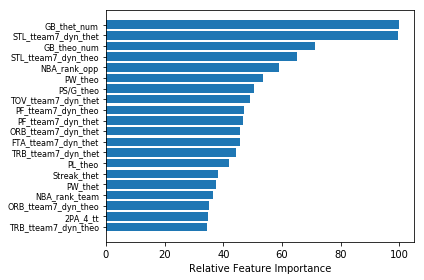

In [47]:
maxx=len(feature_importance)
print(maxx)
numb=20
import matplotlib.pyplot as plt
feature_importance = abs(model_lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos[maxx-numb:], feature_importance[sorted_idx][maxx-numb:], align='center')
featax.set_yticks(pos[maxx-numb:])
featax.set_yticklabels(np.array(Xx_train.columns)[sorted_idx][maxx-numb:], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()
# [maxx-numb:]

## regresja logistyczna wybiera regularyzację 'l2' - ridge regression. za najważniejsze uznaje m.in. takie zmienne związane z miejscem drużyny w tabeli względem najlepszej drużyny w danej konferencji (GB), statystykami meczowymi (STL, TOV), trendem w ostatniej historii (Streak) 

## SVC
### okazuje się, że SVC najlepsze wyniki dawało przy liniowym jądrze. jednakże, przy puszczeniu szerokiego GridSearch-a, kłopoty obliczeniowe nie pozwoliły na uzyskanie wyników dla SVC z powodu obciążeń związanych z właśnie linowym jądrem (kilkanaście godzin nie wystarczyło na uzyskanie wyników). Należy puścić GridSearch-a tylko dla kernel=linear z nadzieją na odtworzenie pierwotnego wyniku. Co więcej, liniowy SVC pozwoli na ocenę istotności cech.

In [52]:
models = [
#           [("model",SVC())]
#     ,
          [("model",BaggingClassifier())]
         ]


param_grids = [
#                {"model__kernel":["linear","poly","rbf","sigmoid"], 
#                 "model__degree":[2,3,4,6],
#                 "model__C":[0.0001,0.001,0.01,0.1,1,10,100,1000,10000], 
#                 "model__coef0":[-10,-1,0,0.5,1,10],
#                 "model__gamma":["auto_deprecated", "auto", "scale"],
#                 "model__decision_function_shape":["ovo","ovr"],
#                 "model__shrinking":['True','False']
#                }
#     ,
               {
                   "model__base_estimator":[DecisionTreeClassifier(),LogisticRegression()],
                   "model__n_estimators":[3,5,15,35,50,100],
                   "model__max_features":[10,25,50,100,150,250,500],
                   "model__bootstrap_features":['True','False'],
                   "model__bootstrap":['True','False']
               }
              ]

In [53]:
best_models = []
scorer = []
scale = [("scale",StandardScaler(with_mean=False))]
for pipe, params in zip(models,param_grids):
    
    # sklejamy pipeline: do wektoryzatora dodajemy kolejne kroki -
    # model z ewentualnymi transformacjami
#     pipeline = Pipeline(pipe) 
    pipeline = Pipeline(scale+pipe) # "+" oznacza sklejenie list
    
#     print(pipeline) 
    
    gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, refit=True)
    gs.fit(Xx_train,yy_train)
    pprint.pprint(gs.cv_results_) #wypisujemy ladnie wyniki kroswalidacji
    best_models.append(gs.best_estimator_) # zapisujemy mmodel z najlepszymi parametrami
    scorer.append(gs.scorer_)
    
for best_model in best_models:
    print("Jakosc predykcji: ", accuracy_score(best_model.predict(Xx_test),yy_test), "; Dopasowanie z zb. treningowym: ",accuracy_score(best_model.predict(Xx_train),yy_train))

{'mean_fit_time': array([1.29985332e-01, 1.12722635e-01, 1.61201636e-01, 2.74035692e-01,
       3.49351883e-01, 6.65606499e-01, 9.16204453e-02, 1.27765814e-01,
       2.65143474e-01, 4.72009738e-01, 6.45294825e-01, 1.22852397e+00,
       1.17531459e-01, 1.73747063e-01, 3.71617158e-01, 8.00144990e-01,
       1.12565533e+00, 2.22760844e+00, 1.78333759e-01, 2.54824400e-01,
       6.76158985e-01, 1.48061275e+00, 2.09435558e+00, 4.15204573e+00,
       2.36271938e-01, 3.56765191e-01, 9.52738841e-01, 2.16008790e+00,
       3.30690789e+00, 6.31289625e+00, 4.05508836e-01, 5.90065241e-01,
       1.61259953e+00, 3.73586567e+00, 5.31345201e+00, 1.08438892e+01,
       6.83439811e-01, 1.20424390e+00, 3.29546539e+00, 7.41824349e+00,
       1.07671051e+01, 2.18311570e+01, 7.90858269e-02, 9.13812319e-02,
       1.54109796e-01, 2.65713851e-01, 3.63868554e-01, 6.86470509e-01,
       1.10336542e-01, 1.31765048e-01, 2.71001418e-01, 5.35468658e-01,
       7.17102846e-01, 1.36169402e+00, 1.33934180e-01, 1.83

             'model__bootstrap_features': 'False',
             'model__max_features': 500,
             'model__n_estimators': 5},
            {'model__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'),
             'model__bootstrap': 'True',
             'model__bootstrap_features': 'False',
             'model__max_features': 500,
             'model__n_estimators': 15},
            {'model__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None

             'model__bootstrap_features': 'False',
             'model__max_features': 25,
             'model__n_estimators': 5},
            {'model__base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False),
             'model__bootstrap': 'True',
             'model__bootstrap_features': 'False',
             'model__max_features': 25,
             'model__n_estimators': 15},
            {'model__base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
      

             'model__bootstrap_features': 'False',
             'model__max_features': 500,
             'model__n_estimators': 100}],
 'rank_test_score': array([322, 314, 297, 273, 258, 241, 328, 290, 262, 284, 239, 246, 313,
       319, 290, 248, 202, 221, 307, 315, 271, 237, 227, 209, 295, 286,
       248, 219, 219, 137, 304, 279, 228, 225, 202, 126, 295, 277, 215,
       194, 126, 133, 336, 329, 278, 299, 275, 260, 334, 327, 264, 214,
       255, 211, 319, 273, 232, 269, 197, 228, 329, 306, 247, 250, 215,
       184, 323, 302, 260, 215, 180, 146, 321, 279, 194, 221, 192, 173,
       289, 271, 205, 200, 176, 141, 317, 326, 302, 281, 264, 237, 329,
       325, 250, 168, 264, 252, 335, 307, 262, 258, 164, 166, 318, 264,
       268, 245, 211, 188, 282, 294, 252, 233, 186, 188, 309, 269, 223,
       180, 197, 205, 300, 241, 205, 100, 188, 168, 329, 312, 286, 235,
       293, 255, 333, 323, 275, 240, 223, 211, 315, 301, 209, 252, 241,
       200, 290, 286, 282, 215, 173, 228, 310, 305, 2

In [ ]:
models = [
          [("model",SVC())]
#     ,
#           [("model",BaggingClassifier())]
         ]


param_grids = [
               {"model__kernel":["linear","poly","sigmoid"], 
                "model__degree":[3,6],
                "model__C":[0.0001,0.01,1,10,1000,10000], 
                "model__coef0":[-1.0,0.0,1.0,10.0],
                "model__gamma":["auto_deprecated", "scale"],
                "model__decision_function_shape":["ovo","ovr"]
               }


#                {"model__kernel":["linear","poly","rbf","sigmoid"], 
#                 "model__degree":[2,3,4,6],
#                 "model__C":[0.0001,0.001,0.01,0.1,1,10,100,1000,10000], 
#                 "model__coef0":[-10.0,-1.0,0.0,0.5,1.0,10.0],
#                 "model__gamma":["auto_deprecated", "auto", "scale"],
#                 "model__decision_function_shape":["ovo","ovr"]
#                }
    

              ]

In [ ]:
start_time = time.time()

best_models = []
scorer = []
scale = [("scale",StandardScaler(with_mean=False))]
for pipe, params in zip(models,param_grids):
    
    # sklejamy pipeline: do wektoryzatora dodajemy kolejne kroki -
    # model z ewentualnymi transformacjami
#     pipeline = Pipeline(pipe) 
    pipeline = Pipeline(scale+pipe) # "+" oznacza sklejenie list
    
#     print(pipeline) 
    
    gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, refit=True, verbose=10)
    gs.fit(Xx_train,yy_train)
    pprint.pprint(gs.cv_results_) #wypisujemy ladnie wyniki kroswalidacji
    best_models.append(gs.best_estimator_) # zapisujemy mmodel z najlepszymi parametrami
    scorer.append(gs.scorer_)
    
for best_model in best_models:
    print("Jakosc predykcji: ", accuracy_score(best_model.predict(Xx_test),yy_test), "; Dopasowanie z zb. treningowym: ",accuracy_score(best_model.predict(Xx_train),yy_train))

with open('best_models_2019_SVC', 'wb') as filehandle:  
    pickle.dump(best_models, filehandle)
    
elapsed_time_secs = time.time() - start_time
msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)  

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3

## osobno, testowany był również alternatywny algorytm do GradientBoostingu:

In [49]:
models = [
          [("model",GradientBoostingClassifier())]
         ]

param_grids = [
                {
                   "model__learning_rate":[0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                   "model__min_samples_split":[0.1, 0.25, 0.5],
                   "model__min_samples_leaf":[0.1, 0.25, 0.5],
                   "model__max_depth":[3,5,8],
#                   "max_features":["log2","sqrt"],
#                   "min_impurity_split":[5e-6, 1e-7, 5e-7],
                  "model__criterion": ["friedman_mse",  "mae"],
#                    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
                  "model__n_estimators":[10]}

              ]

In [50]:
start_time = time.time()

best_models = []
scorer = []
scale = [("scale",StandardScaler(with_mean=False))]
for pipe, params in zip(models,param_grids):
    
    # sklejamy pipeline: do wektoryzatora dodajemy kolejne kroki -
    # model z ewentualnymi transformacjami
#     pipeline = Pipeline(pipe) 
    pipeline = Pipeline(scale+pipe) # "+" oznacza sklejenie list
    
#     print(pipeline) 
    
    gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, refit=True, verbose=10)
    gs.fit(Xx_train,yy_train)
    pprint.pprint(gs.cv_results_) #wypisujemy ladnie wyniki kroswalidacji
    best_models.append(gs.best_estimator_) # zapisujemy mmodel z najlepszymi parametrami
    scorer.append(gs.scorer_)
    
for best_model in best_models:
    print("Jakosc predykcji: ", accuracy_score(best_model.predict(Xx_test),yy_test), "; Dopasowanie z zb. treningowym: ",accuracy_score(best_model.predict(Xx_train),yy_train))

with open('best_models_2019_GBclassif', 'wb') as filehandle:  
    pickle.dump(best_models, filehandle)
    
elapsed_time_secs = time.time() - start_time
msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
print(msg)  

Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

{'mean_fit_time': array([  1.90384634,   1.79123982,   0.95432512,   1.06207561,
         0.9429663 ,   1.03711081,   0.52069465,   0.69907586,
         0.57284649,   2.20538068,   2.08352653,   1.13976852,
         0.99135248,   1.01192482,   1.10674262,   0.65100225,
         0.60267727,   0.6864957 ,   2.3775603 ,   2.020365  ,
         1.11234816,   1.02377629,   1.06572358,   1.16817482,
         0.71399244,   0.5389924 ,   0.58925017,   1.87533021,
         1.95054213,   1.11932309,   0.93853585,   1.17105929,
         1.12716301,   0.5900987 ,   0.65035828,   0.61903564,
         2.25521294,   1.81493783,   1.03823646,   0.96066737,
         1.01379681,   0.94913681,   0.60042445,   0.55539306,
         0.5447065 ,   2.32521566,   2.04918543,   1.16219123,
         1.05518134,   1.14616187,   1.05133684,   0.64420636,
         0.66511766,   0.6077656 ,   1.98211177,   1.94820539,
         1.23446584,   1.03560797,   1.00933838,   0.97441904,
         0.53152831,   0.57894357,   

             'model__min_samples_leaf': 0.5,
             'model__min_samples_split': 0.5,
             'model__n_estimators': 10},
            {'model__criterion': 'friedman_mse',
             'model__learning_rate': 0.1,
             'model__max_depth': 8,
             'model__min_samples_leaf': 0.1,
             'model__min_samples_split': 0.1,
             'model__n_estimators': 10},
            {'model__criterion': 'friedman_mse',
             'model__learning_rate': 0.1,
             'model__max_depth': 8,
             'model__min_samples_leaf': 0.1,
             'model__min_samples_split': 0.25,
             'model__n_estimators': 10},
            {'model__criterion': 'friedman_mse',
             'model__learning_rate': 0.1,
             'model__max_depth': 8,
             'model__min_samples_leaf': 0.1,
             'model__min_samples_split': 0.5,
             'model__n_estimators': 10},
            {'model__criterion': 'friedman_mse',
             'model__learning_rate': 0.1,

             'model__max_depth': 5,
             'model__min_samples_leaf': 0.1,
             'model__min_samples_split': 0.1,
             'model__n_estimators': 10},
            {'model__criterion': 'mae',
             'model__learning_rate': 0.075,
             'model__max_depth': 5,
             'model__min_samples_leaf': 0.1,
             'model__min_samples_split': 0.25,
             'model__n_estimators': 10},
            {'model__criterion': 'mae',
             'model__learning_rate': 0.075,
             'model__max_depth': 5,
             'model__min_samples_leaf': 0.1,
             'model__min_samples_split': 0.5,
             'model__n_estimators': 10},
            {'model__criterion': 'mae',
             'model__learning_rate': 0.075,
             'model__max_depth': 5,
             'model__min_samples_leaf': 0.25,
             'model__min_samples_split': 0.1,
             'model__n_estimators': 10},
            {'model__criterion': 'mae',
             'model__learning_rate

Jakosc predykcji:  0.6563786008230452 ; Dopasowanie z zb. treningowym:  0.6992790937178167
Execution took: 1:53:38 secs (Wall clock time)


In [51]:
best_models

[Pipeline(memory=None,
          steps=[('scale',
                  StandardScaler(copy=True, with_mean=False, with_std=True)),
                 ('model',
                  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                             learning_rate=0.15, loss='deviance',
                                             max_depth=5, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=0.1,
                                             min_samples_split=0.25,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10,
                                             n_iter_no_change=None,
                                             presort='a

## algorytm ten daje lepsze wyniki niż (przeuczony) algorytm XGBoost
### dodatkowo, dla najlepszego modelu można wskazać najważniejsze cechy, są nimi m.in. ilość fanów, udział najlepszych 5 graczy w zwyciestwach swojej drużyny, fakt grania na swoim boisku.

In [58]:
model_gb = GradientBoostingClassifier(learning_rate=0.15,
                   min_samples_split=0.25,
                   min_samples_leaf=0.1,
                   max_depth=5,
                   criterion="friedman_mse",
                   n_estimators=10)

model_gb.fit(Xx_train,yy_train)
accuracy_score(model_gb.predict(Xx_test),yy_test)


0.6563786008230452

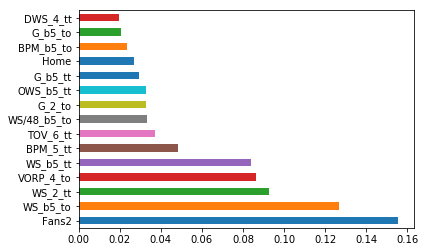

In [59]:
%matplotlib inline 
(pd.Series(model_gb.feature_importances_, index=Xx_train.columns)
   .nlargest(15)
   .plot(kind='barh')) 

# Podsumowanie

## Uzyskane wyniki pozwalają uznać, że dzięki modelom można lepiej przewidywać wygraną. Kolejne kroki (przykładowe; na kolejny projekt):
### 1. dynamizacja statystyk zawodników
### 2. testowanie modelu na podpróbkach (być może model precycyjniej typuje mecze, gdzie łatwo wskazać faworyta)
### 3. rozbudowanie zbioru o historyczne sezony
### 4. GridSearch dla SVC tylko dla kernel='linear'